Methods
- Method overview
    - GLM
    - Moving average
    - BMA clusters
- Data/case study
    - SWA Data
- Model formulation
- Model parametrisation
    - The GLM is parameterised by water, emission, and normalised by area with yield as the predicted variable.
    - Clusters is done along multiple axes
- Performance measures
- Sensitivity analysis 
    
Results
- Compare variables and their distributions
- Compare regions and their distributions
    - Look at the bias in data towards certain regions
    - And, look at the bias in recording of certain variables
- Look at the GLM
    - What regions stand out within the model and what does it explain
- Look at the clusters
     - Can this be explained by regional differences
- Sensitivity analysis

### We have to clean up the data a little bit for this analysis.

We are going to remove a swath of rows that do not include enough information. This means we will deal with a subset of the data that were willing to report enough variables for the analysis to make sense. The baseline variables are fuel, water, area and yield.

In [1]:
# We import some libraries and read in the data
from carbon_converter import *
from data import *
from graph import multihist

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rpy2
import rpy2.robjects as robjects
import rpy2.ipython.html

df = pd.read_feather('df.feather')
# TODO
# add nitrogen/fertiliser added together in data pipeline
df['nitrogen_applied'] = df['synthetic_nitrogen_applied']+df['organic_nitrogen_applied']
df['fertiliser_applied'] = df['synthetic_fertiliser_applied']+df['organic_fertiliser_applied']

df["fertiliser"] = df['fertiliser_applied'] + df['nitrogen_applied']

# negative vineyard area harvested or likely typos
for id in df[df['area_harvested']<0.01].index:
    df = df.drop(index=id)
# remove radical outliers - caused mostly by incorrect units.
for id in df[df['water_used']>1000000].index:
    df = df.drop(index=id)
    
# There are a couple of average sale prices that are 1, which is not a realistic value. So we remove them
df.loc[1848, "average_per_tonne"] = np.nan
df.loc[5493, "average_per_tonne"] = np.nan

n*** Successfully loaded .Rprofile ***n


In [5]:
# There are some errors in spray data

df.loc[
    (df["insecticide_spraying_number_of_times_passes_per_year"]<1) & 
    (df["insecticide_spraying_number_of_times_passes_per_year"]!=0)
    , "insecticide_spraying_number_of_times_passes_per_year"] = 0


df.loc[
    (df["herbicide_spraying_number_of_times_passes_per_year"]<1) & 
    (df["herbicide_spraying_number_of_times_passes_per_year"]!=0)
    , "herbicide_spraying_number_of_times_passes_per_year"] = 0


In [6]:
# We convert the use of fuels into CO2E
# This includes both scope1 and scope 2 in the totals, as well as separate columns for comparison.
df["total_irrigation_electricity"] = df["total_irrigation_electricity"].apply(scope2)
df["irrigation_energy_diesel"] = df["irrigation_energy_diesel"].apply(diesel_irrigation)
df["irrigation_energy_electricity"] = df["irrigation_energy_electricity"].apply(scope2)
df["irrigation_energy_pressure"] = df["irrigation_energy_pressure"].apply(scope2)
df["diesel_vineyard"] = df["diesel_vineyard"].apply(diesel_vehicle)
df["electricity_vineyard"] = df["electricity_vineyard"].apply(scope2)
df["petrol_vineyard"] = df["petrol_vineyard"].apply(petrol_vehicle)
df["lpg_vineyard"] = df["lpg_vineyard"].apply(lpg_vehicle)
df["biodiesel_vineyard"] = df["biodiesel_vineyard"].apply(biodiesel_vehicle)

df["use_renewable"] = 0
df.loc[(df["irrigation_energy_solar"]>0) | (df["vineyard_wind"]>0) | (df["vineyard_solar"]),"use_renewable"] += 1

df["scope2"] = df["total_irrigation_electricity"]\
    + df["irrigation_energy_electricity"]\
    + df["irrigation_energy_pressure"]\
    + df["electricity_vineyard"]

df["scope1"] = df["irrigation_energy_diesel"]\
    + df["diesel_vineyard"]\
    + df["petrol_vineyard"]\
    + df["lpg_vineyard"]\
    + df["biodiesel_vineyard"]

df["total_emissions"] = df["scope1"] + df["scope2"]


In [7]:
# we limit it to recordings for the baseline variables.
df = df.replace({0: np.nan})
df = df[(df["area_harvested"].notnull()) & (df["tonnes_grapes_harvested"].notnull()) & (df["water_used"].notnull()) & (df["total_vineyard_fuel"].notnull())]


In [8]:
# We are going to transform the data so that it is distributed normally.
# This involves removing the top and bottom 1% as they contain several radicals
#
# These radicals may be mis recordings or freak events in the data. They are 
# disparate enough to remove.

log_df = df.copy()
log_df["area_harvested"] += 1

ids = []
for col in [
    "water_used"
    , "tonnes_grapes_harvested"
    , "total_vineyard_fuel"
    , "total_vineyard_electricity"
    , "fertiliser"
]:
    log_df[col] = log_df[col].apply(np.log).div(log_df["area_harvested"].apply(np.log))

    #log_df = log_df.loc[
    #    log_df[col].sort_values().iloc[round(len(log_df)*.005):round(len(log_df)-len(df)*.005)].index
    #]

for col in [
    "total_emissions"
    , "scope1"
    , "scope2"
]:
    log_df[col] += 1
    log_df[col] = log_df[col].apply(np.log).div(log_df["area_harvested"].apply(np.log))

### We have a look at the sparsity of particular variables

In [9]:
feature_list = [
    "area_harvested"
    , "tonnes_grapes_harvested"
    , "water_used"
    , "total_tractor_passes"
    , "slashing_number_of_times_passes_per_year"
    , "fungicide_spraying_number_of_times_passes_per_year"
    , "herbicide_spraying_number_of_times_passes_per_year"
    , "insecticide_spraying_number_of_times_passes_per_year"
    , "fertiliser"
    , "total_emissions"
]

total = len(log_df)
print("n = {}".format(total))
print("Proportion of entries in each column:\n")
for feature in feature_list:
    entries = len(log_df[log_df[feature].notnull()][feature])
    print("{}: {} | {}%".format(feature, entries, round((entries/total)*100, 2)))

n = 5403
Proportion of entries in each column:

area_harvested: 5403 | 100.0%
tonnes_grapes_harvested: 5403 | 100.0%
water_used: 5403 | 100.0%
total_tractor_passes: 1978 | 36.61%
slashing_number_of_times_passes_per_year: 1939 | 35.89%
fungicide_spraying_number_of_times_passes_per_year: 1923 | 35.59%
herbicide_spraying_number_of_times_passes_per_year: 1736 | 32.13%
insecticide_spraying_number_of_times_passes_per_year: 934 | 17.29%
fertiliser: 712 | 13.18%
total_emissions: 5403 | 100.0%


In [10]:
len(df["member_id"].unique())

1298

In [11]:
# There are two outliers who have used an obscene amount of fuel and water for their vineyard, however these aren ot unrealistic values.
df = df.drop(5642)
df = df.drop(4642)

### We look at the proportion of entries for each region:

In [12]:
total = len(log_df)
print("n = {}".format(total))
print("number of regions is {}".format(len(log_df["giregion"].unique())))
print("Proportion of entries in each column:\n")
for region in log_df["giregion"].unique():
    entries = len(log_df[log_df["giregion"]==region]["giregion"])
    print("{}: {} | {}%".format(region, entries, round((entries/total)*100, 2)))

n = 5403
number of regions is 58
Proportion of entries in each column:

Barossa Valley: 515 | 9.53%
Padthaway: 179 | 3.31%
Hunter Valley: 55 | 1.02%
Coonawarra: 267 | 4.94%
Rutherglen: 29 | 0.54%
Langhorne Creek: 319 | 5.9%
Clare Valley: 126 | 2.33%
Riverland: 445 | 8.24%
Murray Darling: 496 | 9.18%
Upper Goulburn: 20 | 0.37%
Swan Hill: 82 | 1.52%
Adelaide Hills: 410 | 7.59%
Bendigo: 52 | 0.96%
Grampians: 70 | 1.3%
Henty: 20 | 0.37%
Mount Benson: 17 | 0.31%
Wrattonbully: 160 | 2.96%
Robe: 36 | 0.67%
Currency Creek: 20 | 0.37%
Southern Fleurieu: 29 | 0.54%
McLaren Vale: 1025 | 18.97%
Yarra Valley: 108 | 2.0%
Margaret River: 301 | 5.57%
Blackwood Valley: 8 | 0.15%
Glenrowan: 4 | 0.07%
Riverina: 16 | 0.3%
Eden Valley: 89 | 1.65%
Other: 18 | 0.33%
Big Rivers Zone Other: 9 | 0.17%
Heathcote: 28 | 0.52%
Orange: 49 | 0.91%
Kangaroo Island: 10 | 0.19%
0: 22 | 0.41%
Cowra: 6 | 0.11%
Mornington Peninsula: 28 | 0.52%
Adelaide Plains: 25 | 0.46%
Mount Gambier: 9 | 0.17%
Southern Flinders Ranges: 1

In [13]:
log_df.groupby("giregion")["member_id"].count().describe()

count      58.000000
mean       93.155172
std       178.756602
min         1.000000
25%         9.000000
50%        21.000000
75%        79.000000
max      1025.000000
Name: member_id, dtype: float64

In [14]:
region_selection = df.groupby("giregion").count()[(df.groupby("giregion").count()>50)["member_id"]].index.values
region_selection = list(region_selection).append("other")

### How do the variables correlate to each other

In [15]:
df[feature_list].corr().style.background_gradient(cmap='coolwarm')

In [16]:
log_df[feature_list].corr().style.background_gradient(cmap='coolwarm')

### How are the varaible distributed

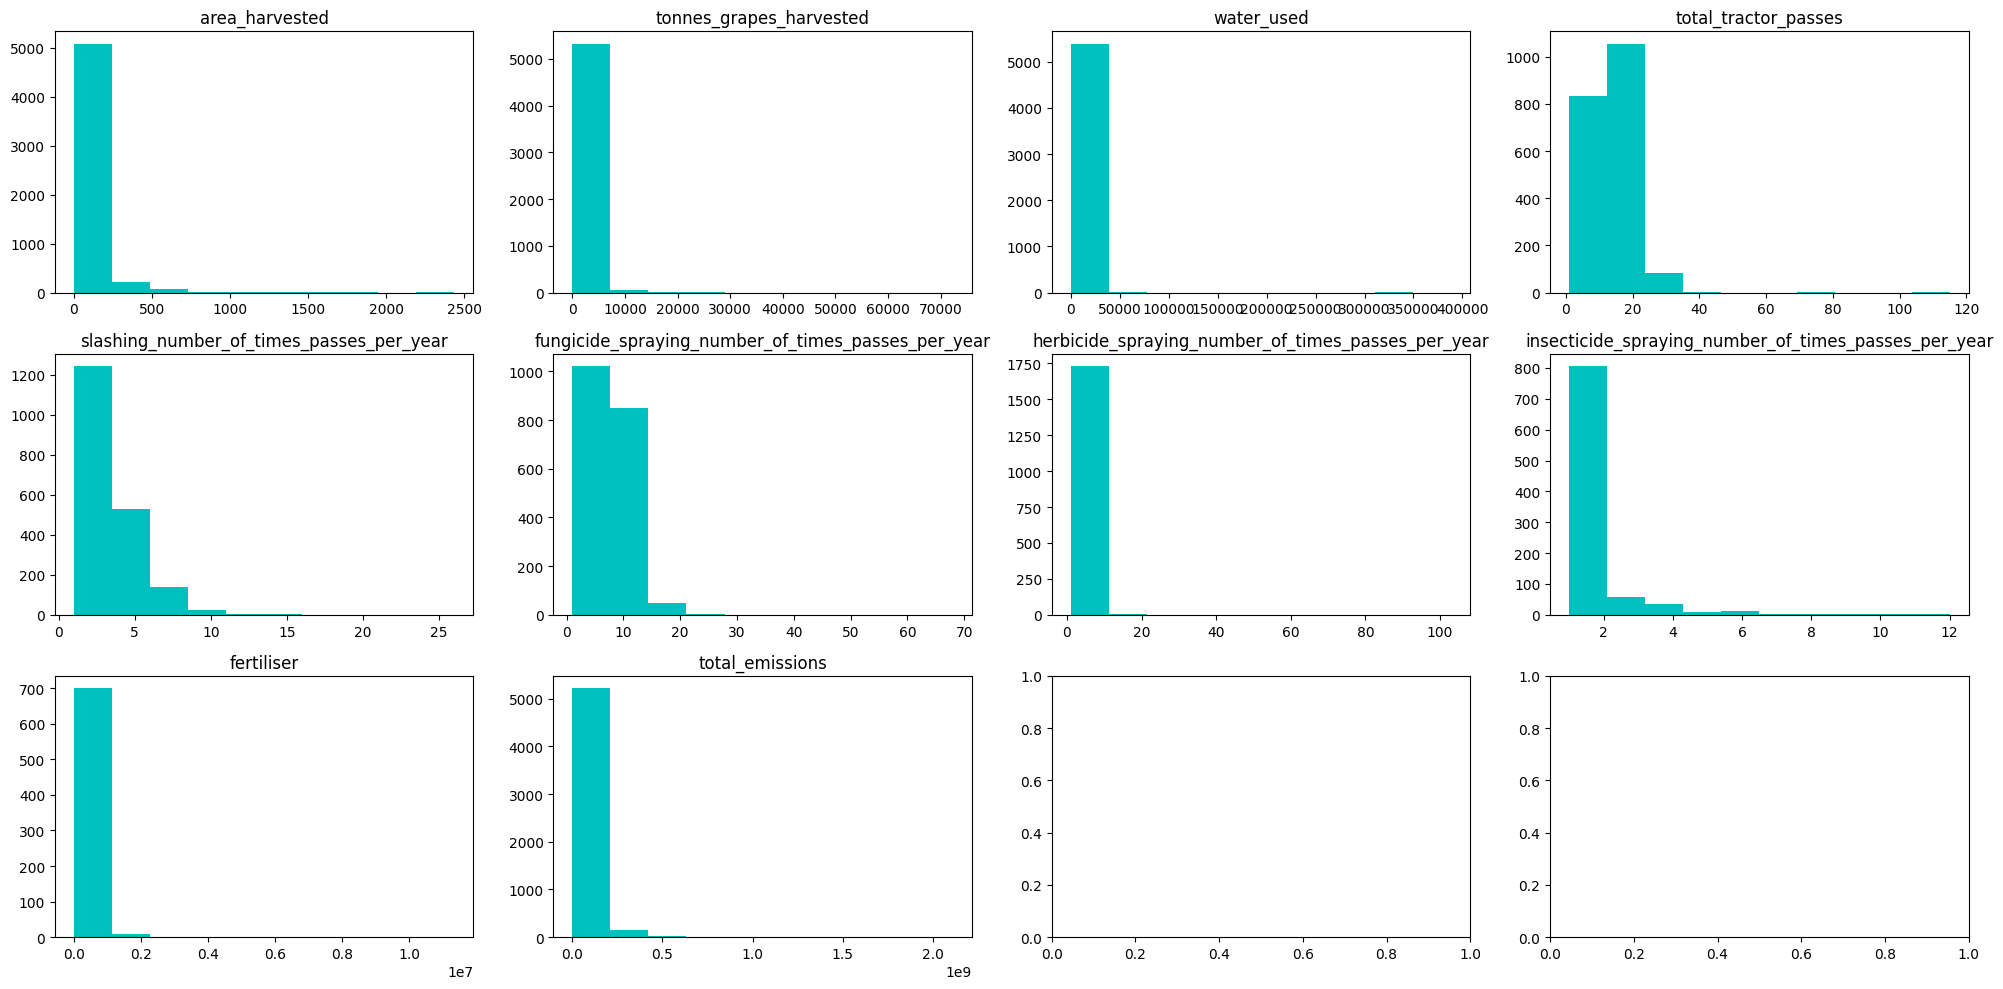

In [17]:
multihist(df[feature_list])
plt.tight_layout()

There are notably two problems with this data. It is skewed due to there being more smalelr wineries than larger, and that there are a few outliers that are likely due to user error. We remove the top and bottom ends and this fixes it.

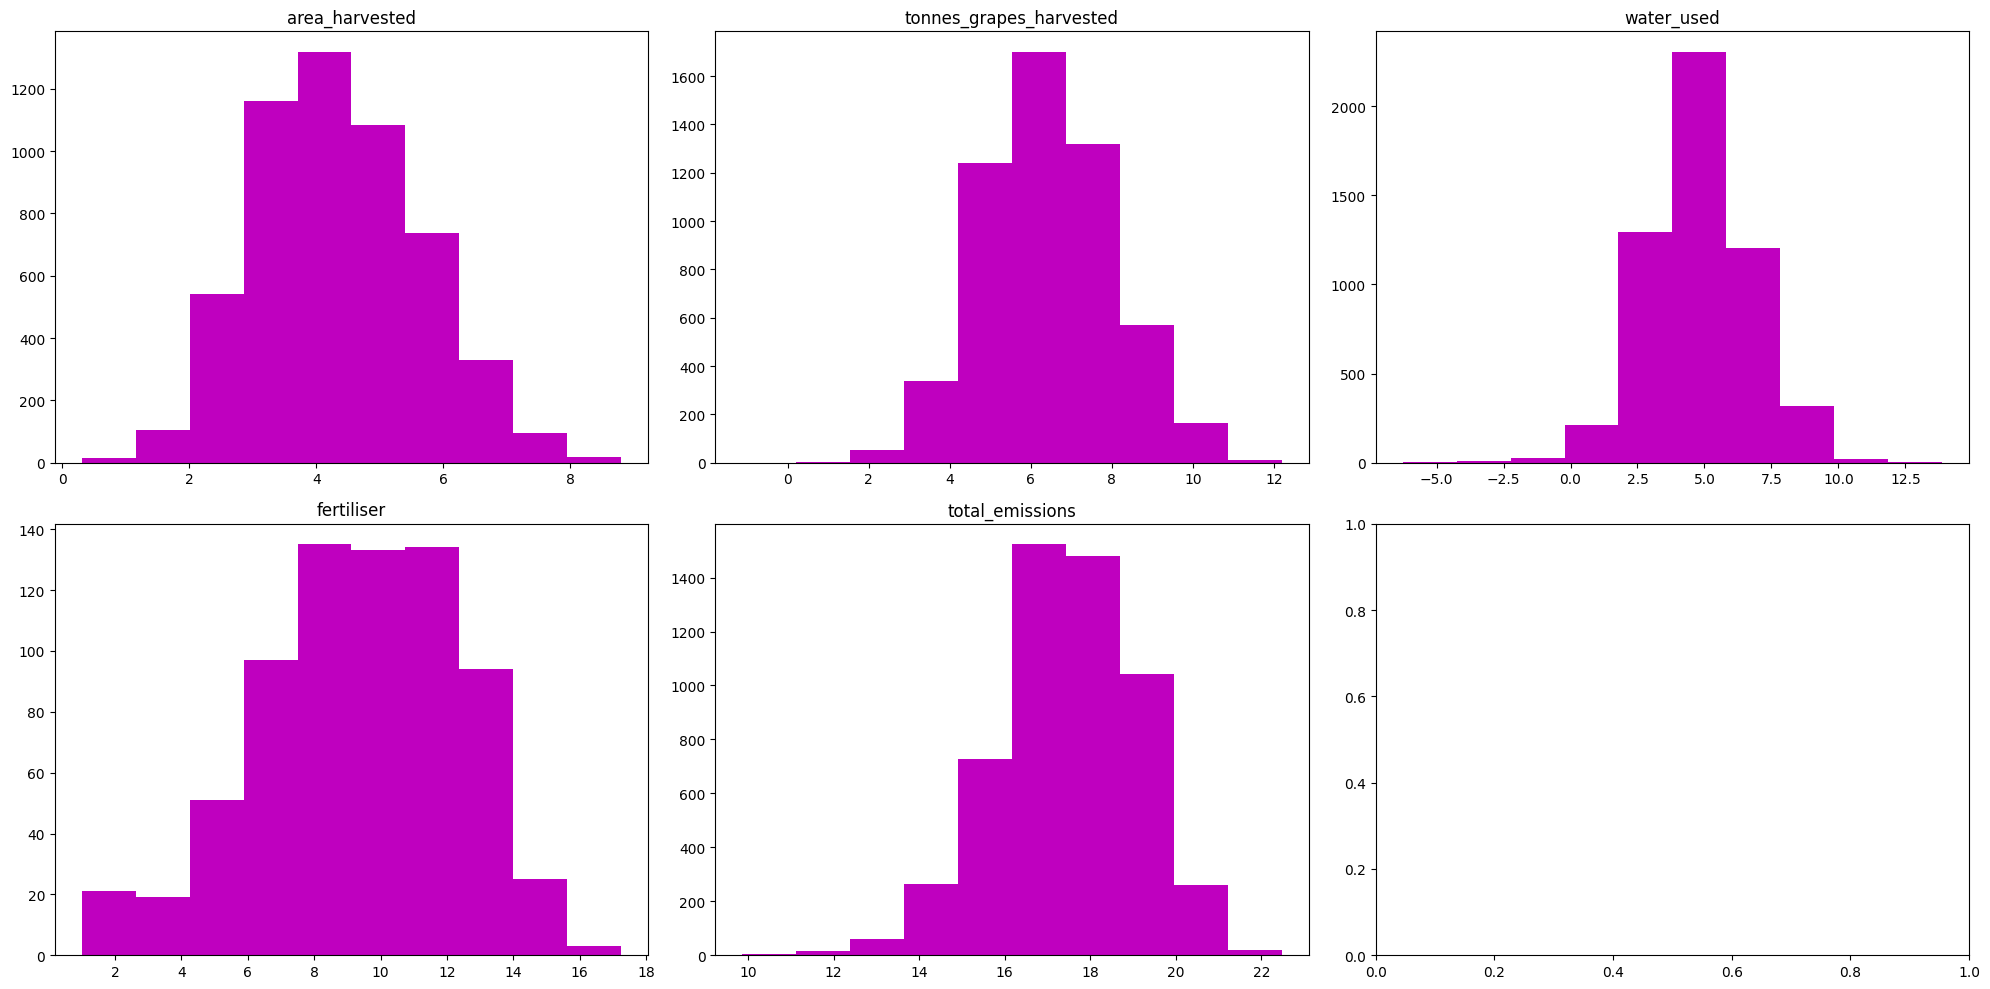

In [18]:
#If values graphed below are overwhelming large then a random error has occurred. Rerun the cell until the dissapear.
fig, ax = multihist(1+df[[
    "area_harvested"
    , "tonnes_grapes_harvested"
    , "water_used"
    , "fertiliser"
    , "total_emissions"
]].apply(np.log), color="m")
plt.tight_layout()

### GLM Baseline

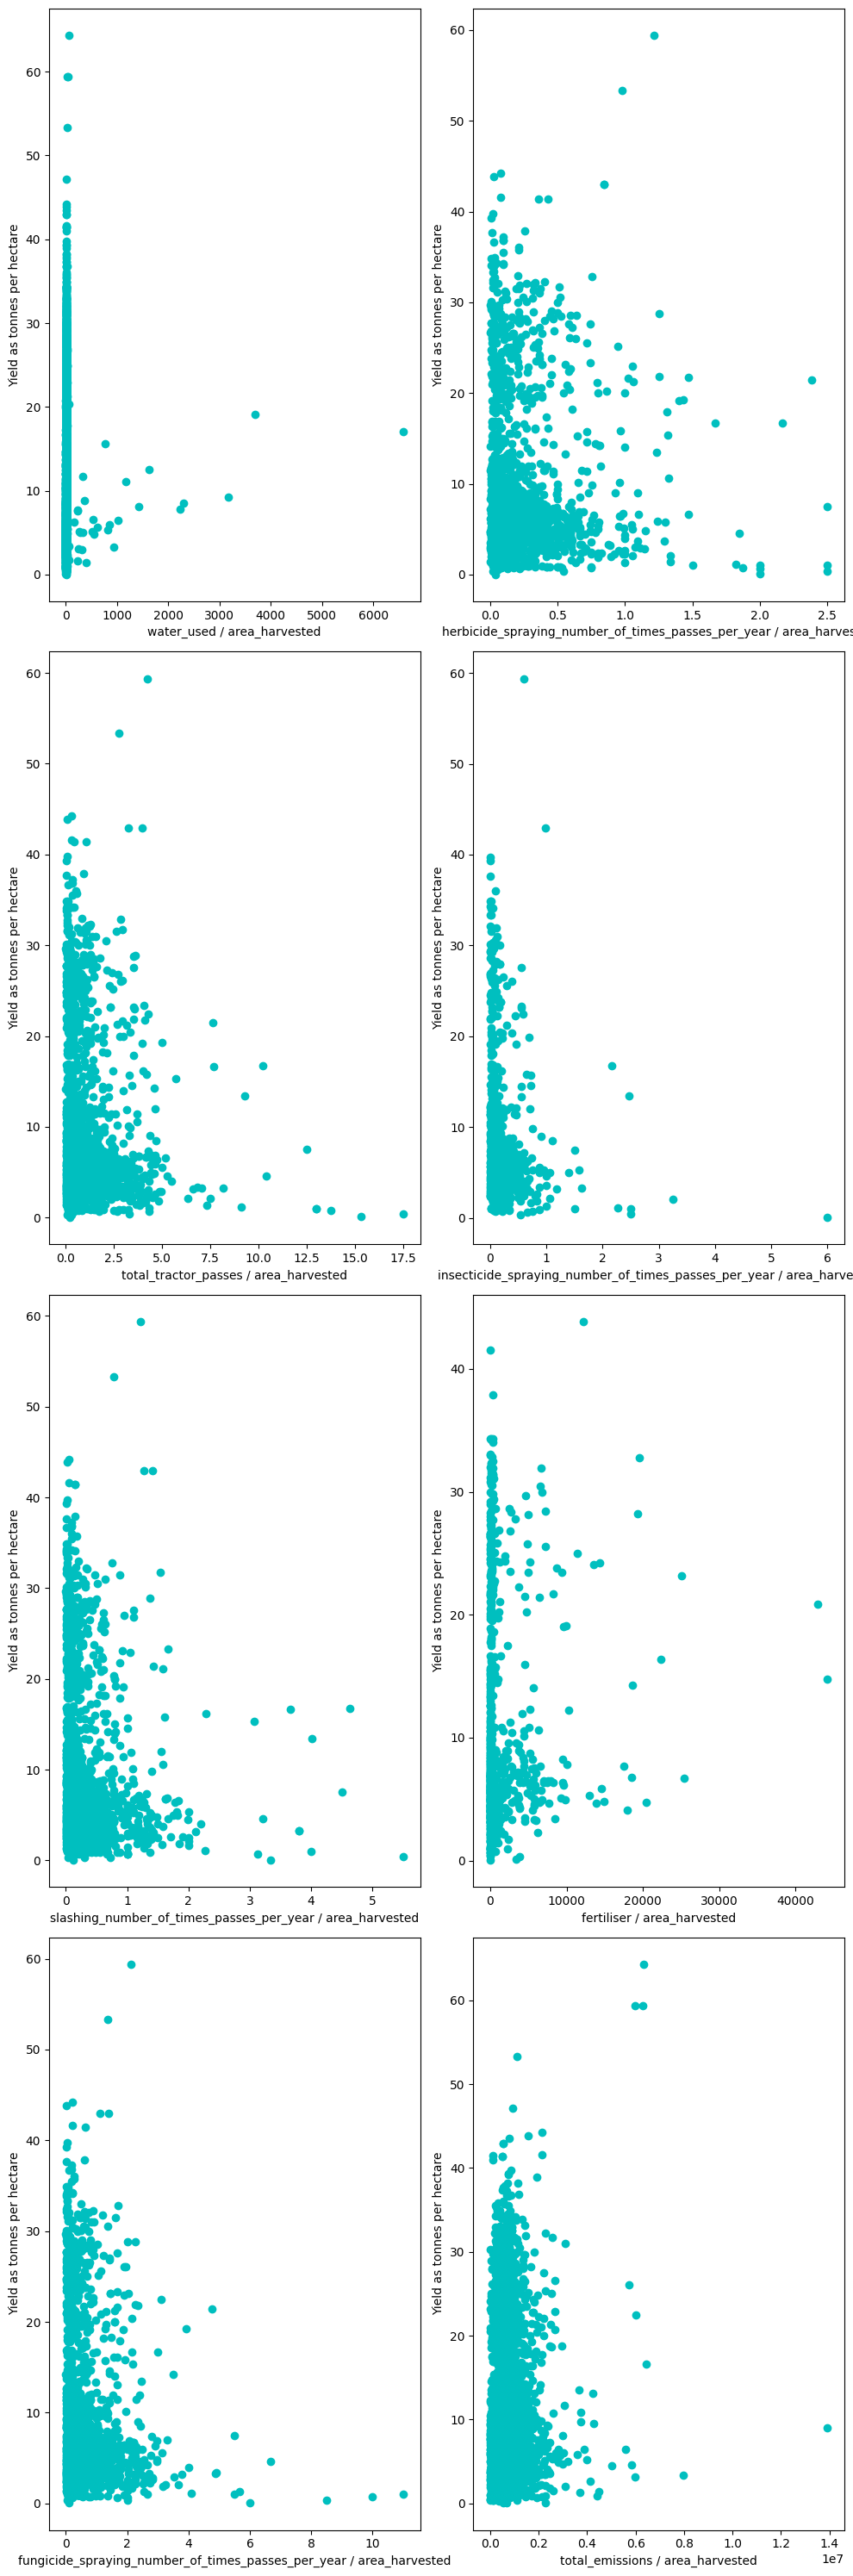

In [19]:
rows = int(round((len(feature_list))/2))-1
cols = 2

fig, ax = plt.subplots(rows, cols, figsize=(10, 30))

i = 0
j = 0
for feature in feature_list:
    if feature == 'tonnes_grapes_harvested':
        continue
    if feature == 'area_harvested':
        continue
    ax[i][j].scatter((1+df[feature]).div(1 + df["area_harvested"]),
                  df['tonnes_grapes_harvested'].div(1+df["area_harvested"]), color="c")
    ax[i][j].set_xlabel("{} / area_harvested".format(feature))
    ax[i][j].set_ylabel("Yield as tonnes per hectare")
    i += 1
    if i == rows:
        j+=1
        i=0

#fig.text(-0.01, 0.5, "Yield as tonnes per hectare", va="center", rotation='vertical')
fig.tight_layout()
plt.show()

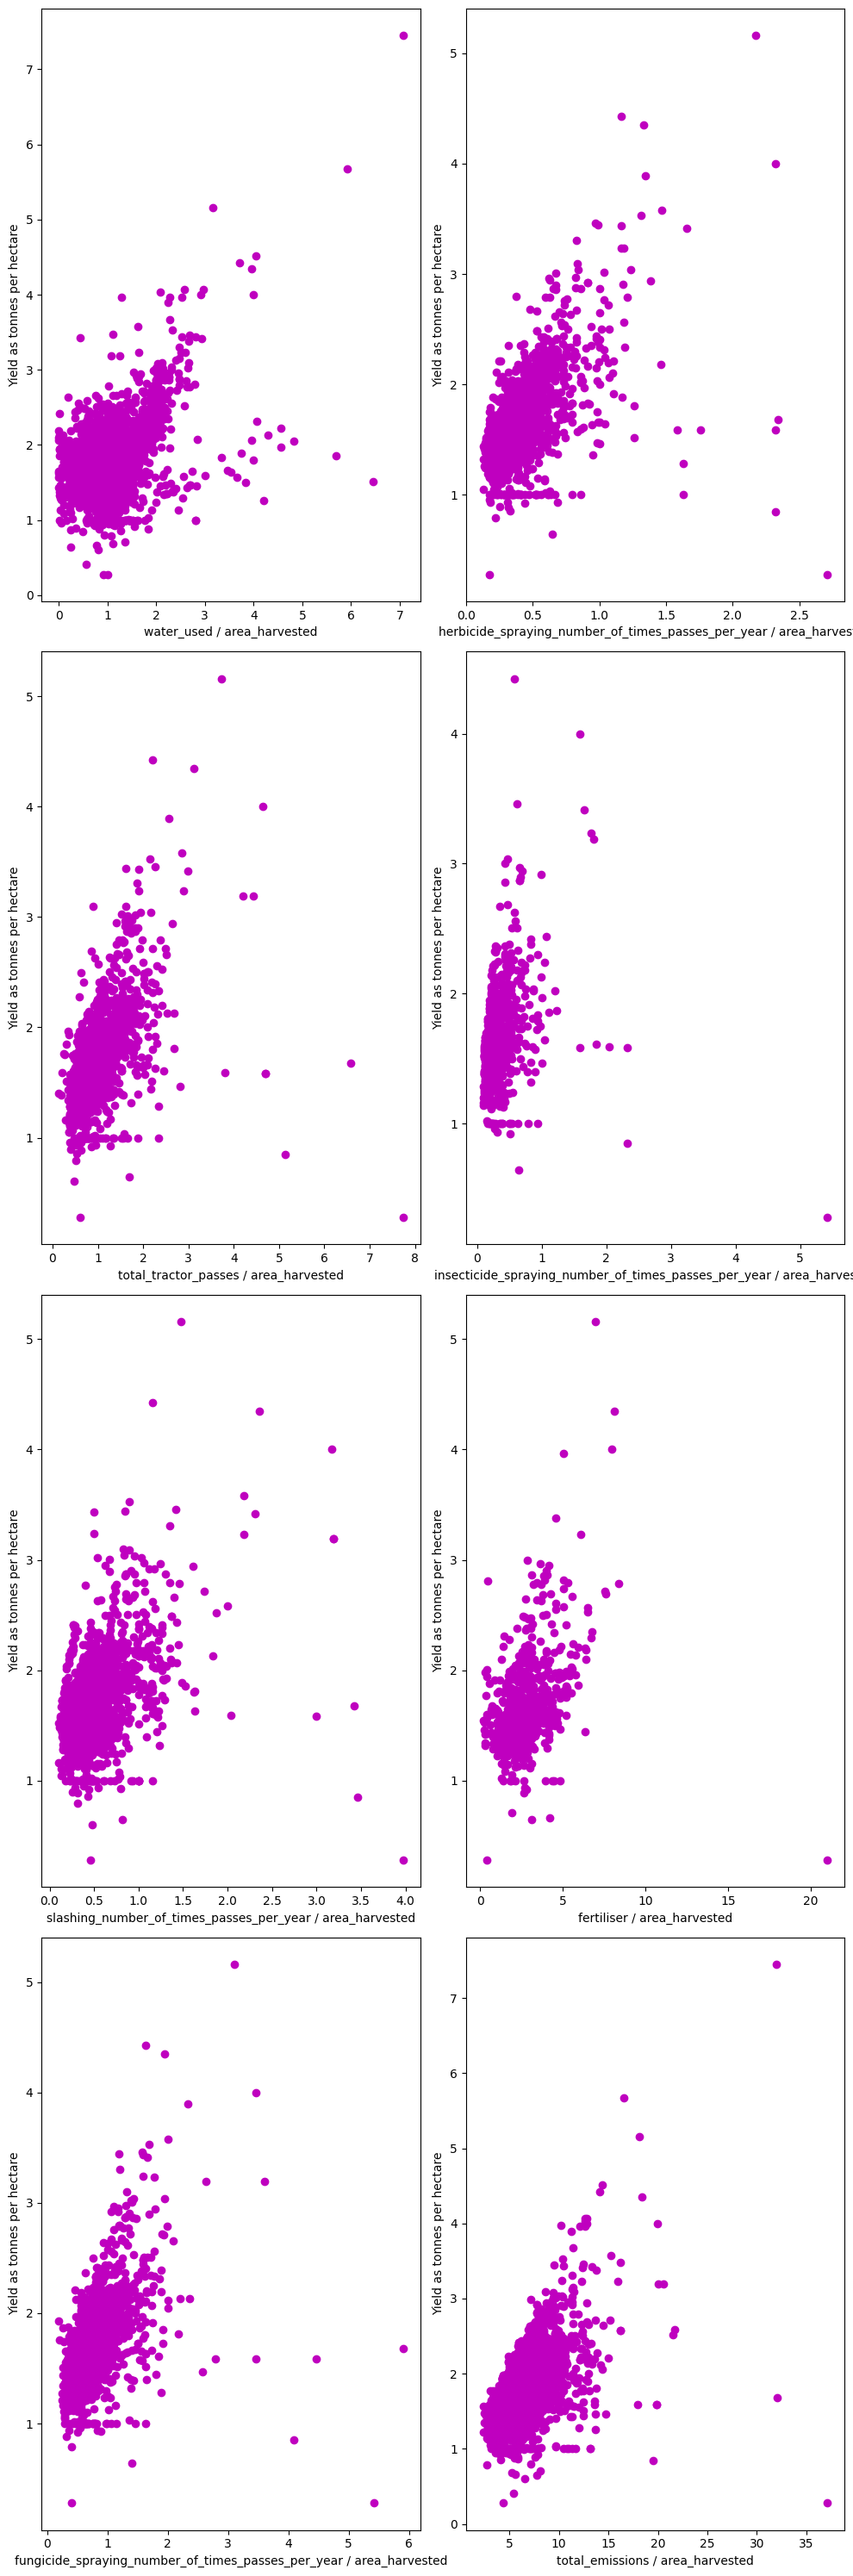

In [20]:
rows = int(round((len(feature_list))/2))-1
cols = 2

fig, ax = plt.subplots(rows, cols, figsize=(10, 30))

i = 0
j=0
for feature in feature_list:
    if feature == 'tonnes_grapes_harvested':
        continue
    if feature == 'area_harvested':
        continue 
    ax[i][j].scatter(((1+df[feature]).apply(np.log)).div((1+df["area_harvested"]).apply(np.log))
                  , (1+df['tonnes_grapes_harvested']).apply(np.log).div((1+df["area_harvested"]).apply(np.log))
                  , color="m")
    ax[i][j].set_xlabel("{} / area_harvested".format(feature))
    ax[i][j].set_ylabel("Yield as tonnes per hectare")
    i += 1
    if i == rows:
        j+=1
        i=0
        
#fig.text(0.04, 0.5, "Yield", ha="center", rotation='vertical')
fig.tight_layout()
plt.show()

In [21]:
rpy2.ipython.html.init_printing()
r = robjects.r

df[feature_list].replace({np.nan: 0}).to_csv("data.csv")

r.source("linear_model.r")
r.linear_model("data.csv", "(1+df$tonnes_grapes_harvested)/(1+df$area_harvested)"
    "~ (1+df$total_emissions)/(1+df$area_harvested)"
    "+ (1+df$water_used)/(1+df$area_harvested) "
    "+ (df$total_tractor_passes)"
    "+ (df$slashing_number_of_times_passes_per_year)"
    "+ (df$fungicide_spraying_number_of_times_passes_per_year)"
    "+ (df$herbicide_spraying_number_of_times_passes_per_year)"
    "+ (df$insecticide_spraying_number_of_times_passes_per_year)"
    "+ (1+df$fertiliser)/(1+df$area_harvested)"
)


***************
*    ANOVA    *

Analysis of Deviance Table

Model: gaussian, link: identity

Response: (1 + df$tonnes_grapes_harvested)/(1 + df$area_harvested)

Terms added sequentially (first to last)


                                                        Df Deviance Resid. Df
NULL                                                                     5400
df$total_emissions                                       1   5429.2      5399
df$water_used                                            1    149.4      5398
df$total_tractor_passes                                  1    121.7      5397
df$slashing_number_of_times_passes_per_year              1    807.6      5396
df$fungicide_spraying_number_of_times_passes_per_year    1   1017.1      5395
df$herbicide_spraying_number_of_times_passes_per_year    1   3720.4      5394
df$insecticide_spraying_number_of_times_passes_per_year  1    135.3      5393
df$fertiliser                                            1    491.8      5392
df$total_emiss

<rpy2.robjects.vectors.ListVector object at 0x7fef382e2f00> [RTYPES.VECSXP]
R classes: ('glm', 'lm')
[FloatSexp..., FloatSexp..., FloatSexp..., FloatSexp..., ..., ListSexpV..., StrSexpVe..., NULLType, ListSexpV...]
  coefficients: <class 'rpy2.robjects.vectors.FloatVector'>
  <rpy2.robjects.vectors.FloatVector object at 0x7fef3a6e6480> [RTYPES.REALSXP]
R classes: ('numeric',)
[8.884041, 0.000000, -0.000009, -2.712620, ..., 0.000005, -0.000000, 0.000000, -0.000000]
  residuals: <class 'rpy2.robjects.vectors.FloatVector'>
  <rpy2.robjects.vectors.FloatVector object at 0x7fef3abbde00> [RTYPES.REALSXP]
R classes: ('numeric',)
[-4.101432, -5.780930, -5.318279, -3.060307, ..., -3.841301, 22.840201, 11.667011, -4.983087]
  fitted.values: <class 'rpy2.robjects.vectors.FloatVector'>
  <rpy2.robjects.vectors.FloatVector object at 0x7fef382e16c0> [RTYPES.REALSXP]
R classes: ('numeric',)
[10.089528, 10.461485, 10.405235, 10.186471, ..., 9.041301, 11.407418, 11.106236, 9.660506]
  effects: <class 'rpy2.robjects.vectors.FloatVector'>
  <rpy2.robjects.vectors.FloatVector object at 0x7fef382e1340> [RTYPES.REALSXP]
R classes: ('numeric',)
[-718.849474, -73.683386, 12.224823, 11.033972, ..., -3.999923, 22.740870, 11.635086, -5.188251]
...
<rpy2.robjects.vectors.ListVector object at 0x7fef382e2f00> [RTYPES.VECSXP]
R classes: ('glm', 'lm')
[FloatSexp..., FloatSexp..., FloatSexp..., FloatSexp..., ..., ListSexpV..., StrSexpVe..., NULLType, ListSexpV...]
  qr: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x7fef52fdb040> [RTYPES.STRSXP]
R classes: ('character',)
['glm.fit']
  family: <class 'rpy2.rinterface_lib.sexp.NULLType'>
  <rpy2.rinterface_lib.sexp.NULLType object at 0x7fef7814d300> [RTYPES.NILSXP]
<rpy2.robjects.vectors.ListVector object at 0x7fef382e2f00> [RTYPES.VECSXP]
R classes: ('glm', 'lm')
[FloatSexp..., FloatSexp..., FloatSexp..., FloatSexp..., ..., ListSexpV..., StrSexpVe..., NULLType, ListSexpV...]

In [22]:
rpy2.ipython.html.init_printing()
r = robjects.r

df[feature_list].replace({np.nan: 0}).to_csv("data.csv")

r.source("linear_model.r")
r.linear_model("data.csv", "log(df$tonnes_grapes_harvested+1)/log(df$area_harvested+1)"
    "~ log(df$total_emissions+1)/log(df$area_harvested+1)"
    "+ log(df$water_used+1)/log(df$area_harvested+1) "
    "+ (df$total_tractor_passes)"
    "+ (df$slashing_number_of_times_passes_per_year)"
    "+ (df$fungicide_spraying_number_of_times_passes_per_year)"
    "+ (df$herbicide_spraying_number_of_times_passes_per_year)"
    "+ (df$insecticide_spraying_number_of_times_passes_per_year)"
    "+ log(df$fertiliser+1)/log(df$area_harvested+1)"
)


***************
*    ANOVA    *

Analysis of Deviance Table

Model: gaussian, link: identity

Response: log(df$tonnes_grapes_harvested + 1)/log(df$area_harvested + 1)

Terms added sequentially (first to last)


                                                        Df Deviance Resid. Df
NULL                                                                     5400
log(df$total_emissions + 1)                              1  143.096      5399
log(df$water_used + 1)                                   1    5.902      5398
df$total_tractor_passes                                  1    0.672      5397
df$slashing_number_of_times_passes_per_year              1    0.012      5396
df$fungicide_spraying_number_of_times_passes_per_year    1    0.182      5395
df$herbicide_spraying_number_of_times_passes_per_year    1    1.655      5394
df$insecticide_spraying_number_of_times_passes_per_year  1    0.039      5393
log(df$fertiliser + 1)                                   1    0.418      5392
log(df$t

<rpy2.robjects.vectors.ListVector object at 0x7fef3a6bb780> [RTYPES.VECSXP]
R classes: ('glm', 'lm')
[FloatSexp..., FloatSexp..., FloatSexp..., FloatSexp..., ..., ListSexpV..., StrSexpVe..., NULLType, ListSexpV...]
  coefficients: <class 'rpy2.robjects.vectors.FloatVector'>
  <rpy2.robjects.vectors.FloatVector object at 0x7fef7428af40> [RTYPES.REALSXP]
R classes: ('numeric',)
[1.124850, 0.093093, 0.004390, -0.053136, ..., 0.005161, -0.025249, 0.029950, -0.000830]
  residuals: <class 'rpy2.robjects.vectors.FloatVector'>
  <rpy2.robjects.vectors.FloatVector object at 0x7fefb6bd6b00> [RTYPES.REALSXP]
R classes: ('numeric',)
[-0.047732, -0.108719, -0.054419, 0.009036, ..., 0.143761, 0.130696, 0.144050, -0.082514]
  fitted.values: <class 'rpy2.robjects.vectors.FloatVector'>
  <rpy2.robjects.vectors.FloatVector object at 0x7fef3a6e7e80> [RTYPES.REALSXP]
R classes: ('numeric',)
[1.451670, 1.469612, 1.414161, 1.419271, ..., 2.005062, 1.761448, 1.615365, 1.928063]
  effects: <class 'rpy2.robjects.vectors.FloatVector'>
  <rpy2.robjects.vectors.FloatVector object at 0x7fef3a4abc80> [RTYPES.REALSXP]
R classes: ('numeric',)
[-122.338538, 11.962253, 2.429459, 0.820034, ..., 0.142432, 0.134972, 0.142476, -0.079863]
...
<rpy2.robjects.vectors.ListVector object at 0x7fef3a6bb780> [RTYPES.VECSXP]
R classes: ('glm', 'lm')
[FloatSexp..., FloatSexp..., FloatSexp..., FloatSexp..., ..., ListSexpV..., StrSexpVe..., NULLType, ListSexpV...]
  qr: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x7fef3a8c3e80> [RTYPES.STRSXP]
R classes: ('character',)
['glm.fit']
  family: <class 'rpy2.rinterface_lib.sexp.NULLType'>
  <rpy2.rinterface_lib.sexp.NULLType object at 0x7fef7814d300> [RTYPES.NILSXP]
<rpy2.robjects.vectors.ListVector object at 0x7fef3a6bb780> [RTYPES.VECSXP]
R classes: ('glm', 'lm')
[FloatSexp..., FloatSexp..., FloatSexp..., FloatSexp..., ..., ListSexpV..., StrSexpVe..., NULLType, ListSexpV...]

In [23]:
rpy2.ipython.html.init_printing()
r = robjects.r

df[feature_list].replace({np.nan: 0}).to_csv("data.csv")

r.source("linear_model.r")
r.linear_model("data.csv", "log(df$tonnes_grapes_harvested+1)/log(df$area_harvested+1)"
    "~ log(df$total_emissions+1)/log(df$area_harvested+1)"
    "+ log(df$water_used+1)/log(df$area_harvested+1) "
    "+ log(df$water_used+1)/log(df$area_harvested+1)"
    "+ log(df$fertiliser + 1)"
)


***************
*    ANOVA    *

Analysis of Deviance Table

Model: gaussian, link: identity

Response: log(df$tonnes_grapes_harvested + 1)/log(df$area_harvested + 1)

Terms added sequentially (first to last)


                                                       Df Deviance Resid. Df
NULL                                                                    5400
log(df$total_emissions + 1)                             1  143.096      5399
log(df$water_used + 1)                                  1    5.902      5398
log(df$fertiliser + 1)                                  1    0.553      5397
log(df$total_emissions + 1):log(df$area_harvested + 1)  1  144.728      5396
log(df$area_harvested + 1):log(df$water_used + 1)       1   19.904      5395
                                                       Resid. Dev
NULL                                                       757.43
log(df$total_emissions + 1)                                614.33
log(df$water_used + 1)                             

<rpy2.robjects.vectors.ListVector object at 0x7fef3abc5680> [RTYPES.VECSXP]
R classes: ('glm', 'lm')
[FloatSexp..., FloatSexp..., FloatSexp..., FloatSexp..., ..., ListSexpV..., StrSexpVe..., NULLType, ListSexpV...]
  coefficients: <class 'rpy2.robjects.vectors.FloatVector'>
  <rpy2.robjects.vectors.FloatVector object at 0x7fef3a7bc400> [RTYPES.REALSXP]
R classes: ('numeric',)
[1.141433, 0.091254, 0.007322, 0.002188, -0.025141, 0.029514]
  residuals: <class 'rpy2.robjects.vectors.FloatVector'>
  <rpy2.robjects.vectors.FloatVector object at 0x7fef701d6400> [RTYPES.REALSXP]
R classes: ('numeric',)
[-0.044815, -0.105267, -0.051131, 0.005588, ..., 0.146075, 0.149681, 0.148250, -0.068134]
  fitted.values: <class 'rpy2.robjects.vectors.FloatVector'>
  <rpy2.robjects.vectors.FloatVector object at 0x7fef3abbe8c0> [RTYPES.REALSXP]
R classes: ('numeric',)
[1.448753, 1.466159, 1.410873, 1.422719, ..., 2.002749, 1.742464, 1.611165, 1.913683]
  effects: <class 'rpy2.robjects.vectors.FloatVector'>
  <rpy2.robjects.vectors.FloatVector object at 0x7fef3abbe840> [RTYPES.REALSXP]
R classes: ('numeric',)
[-122.338538, 11.962253, 2.429459, -0.743629, ..., 0.144093, 0.152278, 0.149313, -0.065556]
...
<rpy2.robjects.vectors.ListVector object at 0x7fef3abc5680> [RTYPES.VECSXP]
R classes: ('glm', 'lm')
[FloatSexp..., FloatSexp..., FloatSexp..., FloatSexp..., ..., ListSexpV..., StrSexpVe..., NULLType, ListSexpV...]
  qr: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x7fef75528e40> [RTYPES.STRSXP]
R classes: ('character',)
['glm.fit']
  family: <class 'rpy2.rinterface_lib.sexp.NULLType'>
  <rpy2.rinterface_lib.sexp.NULLType object at 0x7fef7814d300> [RTYPES.NILSXP]
<rpy2.robjects.vectors.ListVector object at 0x7fef3abc5680> [RTYPES.VECSXP]
R classes: ('glm', 'lm')
[FloatSexp..., FloatSexp..., FloatSexp..., FloatSexp..., ..., ListSexpV..., StrSexpVe..., NULLType, ListSexpV...]

In [24]:
rpy2.ipython.html.init_printing()
r = robjects.r

df.to_csv("data.csv")

r.source("linear_model.r")
model = r.linear_model("data.csv", "log(df$tonnes_grapes_harvested+1)/log(df$area_harvested+1)"
    "~ log(df$total_emissions+1)/log(df$area_harvested+1) "
    "+ log(df$water_used+1)/log(df$area_harvested+1) "
)


***************
*    ANOVA    *

Analysis of Deviance Table

Model: gaussian, link: identity

Response: log(df$tonnes_grapes_harvested + 1)/log(df$area_harvested + 1)

Terms added sequentially (first to last)


                                                       Df Deviance Resid. Df
NULL                                                                    5400
log(df$total_emissions + 1)                             1  143.096      5399
log(df$water_used + 1)                                  1    5.902      5398
log(df$total_emissions + 1):log(df$area_harvested + 1)  1  144.982      5397
log(df$area_harvested + 1):log(df$water_used + 1)       1   19.968      5396
                                                       Resid. Dev
NULL                                                       757.43
log(df$total_emissions + 1)                                614.33
log(df$water_used + 1)                                     608.43
log(df$total_emissions + 1):log(df$area_harvested + 1)     463

In [25]:
model[4]

<rpy2.robjects.vectors.FloatMatrix object at 0x7fef3a75d7c0> [RTYPES.REALSXP]
R classes: ('matrix', 'array')
[-73.491496, 0.000000, 0.000000, 0.000000, ..., -639.056346, 463.372403, -222.237113, 151.174023]

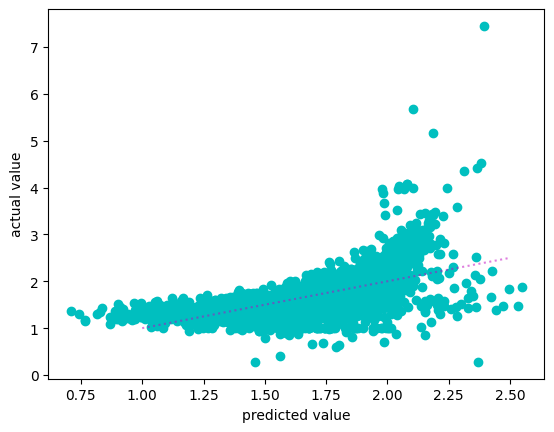

In [26]:
fig, ax = plt.subplots()

plt.plot([1,2.5], [1,2.5], color='m', linestyle='dotted', alpha=0.5)
plt.scatter(model[2]
    , model[17]
    , color="c")

plt.xlabel("predicted value")
plt.ylabel("actual value")

plt.show()    

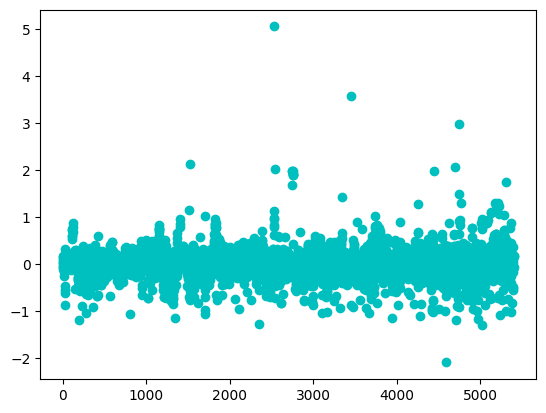

In [27]:
residuals = model[1]
plt.scatter(range(len(residuals)), residuals, color="c")

In [28]:
np.std(np.array(residuals))

0.2865495791504786

In [29]:
np.max(np.array(residuals))

5.0552580455637965

In [30]:
np.min(np.array(residuals))

-2.09142314067037

(array([1.000e+00, 0.000e+00, 1.500e+01, 8.400e+01, 3.250e+02, 2.932e+03,
        1.800e+03, 1.770e+02, 4.100e+01, 9.000e+00, 3.000e+00, 1.100e+01,
        0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([-2.09142314, -1.73408908, -1.37675502, -1.01942096, -0.6620869 ,
        -0.30475284,  0.05258122,  0.40991527,  0.76724933,  1.12458339,
         1.48191745,  1.83925151,  2.19658557,  2.55391963,  2.91125369,
         3.26858775,  3.62592181,  3.98325587,  4.34058993,  4.69792399,
         5.05525805]),
 <BarContainer object of 20 artists>)

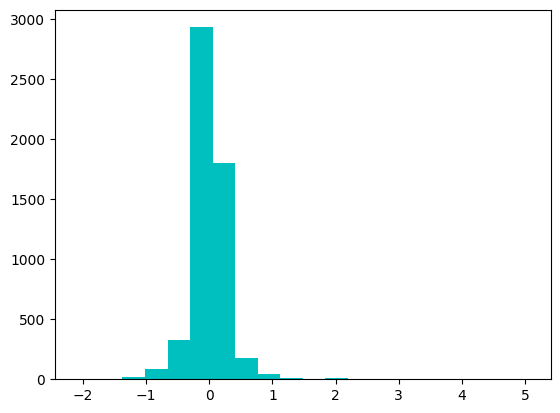

In [31]:
plt.hist(residuals, bins=20, color="c")

In [32]:
from scipy.stats import shapiro

shapiro(residuals)

/home/bryce/repositories/paper_one/venv/lib/python3.10/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.8334167003631592, pvalue=0.0)

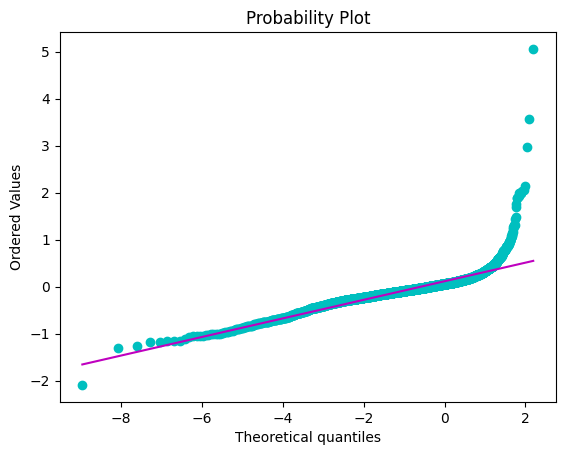

In [33]:
from scipy import stats



fig, ax = plt.subplots()

stats.probplot(
    residuals
    , dist=stats.loggamma
    , sparams=(1)
    , plot=ax
)
ax.get_lines()[0].set_color("c")
ax.get_lines()[1].set_color("m")

plt.show()    

### ???

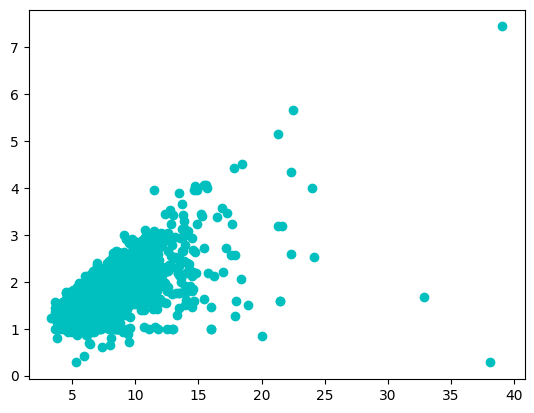

In [34]:
df["water_and_emmissions"] = (1+df["water_used"]).apply(np.log).div((1+df["area_harvested"]).apply(np.log)) +\
            ((1+df["total_emissions"]).apply(np.log).div((1+df["area_harvested"]).apply(np.log)))
df["yield"] = (1+df['tonnes_grapes_harvested']).apply(np.log).div((1+df["area_harvested"]).apply(np.log))

plt.scatter(df["water_and_emmissions"], df["yield"], color="c")


plt.show()

In [35]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(df[feature_list].replace({np.nan: 0}))
for i in range(len(pca.explained_variance_ratio_)):
    print("{}: {}".format(feature_list[i], pca.explained_variance_ratio_[i]))
    print("{}: {}".format(feature_list[i], pca.singular_values_[i]))

area_harvested: 0.9999957505688422
area_harvested: 6362172570.883207
tonnes_grapes_harvested: 4.237540463000941e-06
tonnes_grapes_harvested: 13096742.742274506
water_used: 1.1603175284088628e-08
water_used: 685322.1902745741
total_tractor_passes: 2.8705989583832117e-10
total_tractor_passes: 107793.51382646743
slashing_number_of_times_passes_per_year: 4.4875086029634836e-13
slashing_number_of_times_passes_per_year: 4261.956520219104
fungicide_spraying_number_of_times_passes_per_year: 1.0208767565001838e-14
fungicide_spraying_number_of_times_passes_per_year: 642.8253954080972
herbicide_spraying_number_of_times_passes_per_year: 4.0571603251844006e-16
herbicide_spraying_number_of_times_passes_per_year: 128.14965834265314
insecticide_spraying_number_of_times_passes_per_year: 1.8386236499088978e-16
insecticide_spraying_number_of_times_passes_per_year: 86.26860765855845
fertiliser: 7.903711041015286e-17
fertiliser: 56.561627166667236
total_emissions: 2.268577188440781e-20
total_emissions: 0.9

In [36]:
df["total_vineyard_fuel"].sort_values()

4107         2.0
4691         2.0
3691         4.0
3690         4.0
3193         4.0
          ...   
2488    324024.0
2487    337513.0
2832    391048.0
5390    413689.0
5389    614677.0
Name: total_vineyard_fuel, Length: 5401, dtype: float64

In [37]:
region_selection = df.groupby("giregion").count()[(df.groupby("giregion").count()>50)["member_id"]].index.values

import matplotlib.cm as cm

region_color = {}
color = iter(cm.rainbow(np.linspace(0, 1, len(region_selection))))

for i in range(len(region_selection)):
   region_color[region_selection[i]] = i = next(color)

df['colors'] = df[df["giregion"].isin(region_selection)]["giregion"].apply(lambda x: region_color[x])

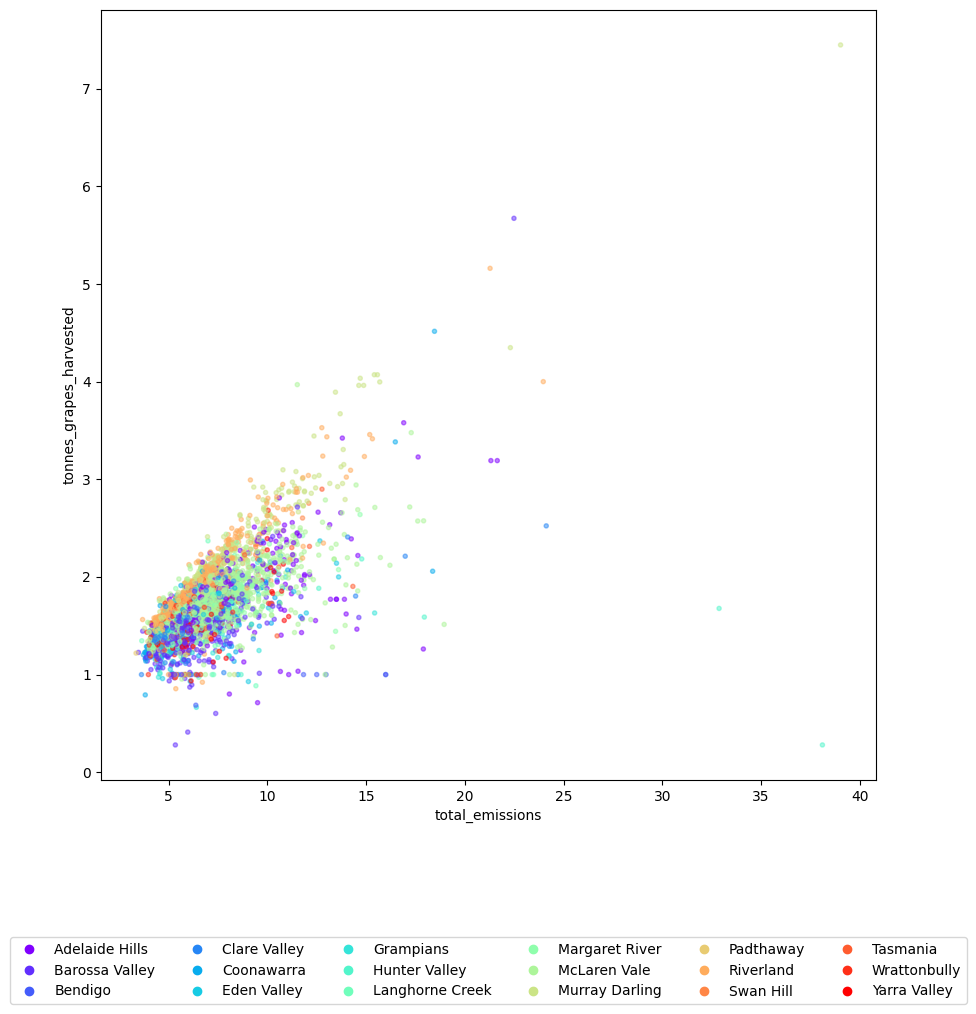

In [38]:
fig, ax = plt.subplots(figsize=(10, 10))

scatter = ax.scatter(
    df[df["giregion"].isin(region_selection)]["water_and_emmissions"],
    df[df["giregion"].isin(region_selection)]['yield'],
    c=df[df["giregion"].isin(region_selection)]["colors"]
    , label=df["giregion"]
    , marker= "."
    , alpha=0.5
)
ax.set_xlabel(feature)
ax.set_ylabel('tonnes_grapes_harvested')
ax.set(xlabel=feature, ylabel='tonnes_grapes_harvested')


markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in region_color.values()]
plt.legend(markers, region_selection, loc='lower center', bbox_to_anchor=(0.5, -.3), ncol=6)

    
plt.show()

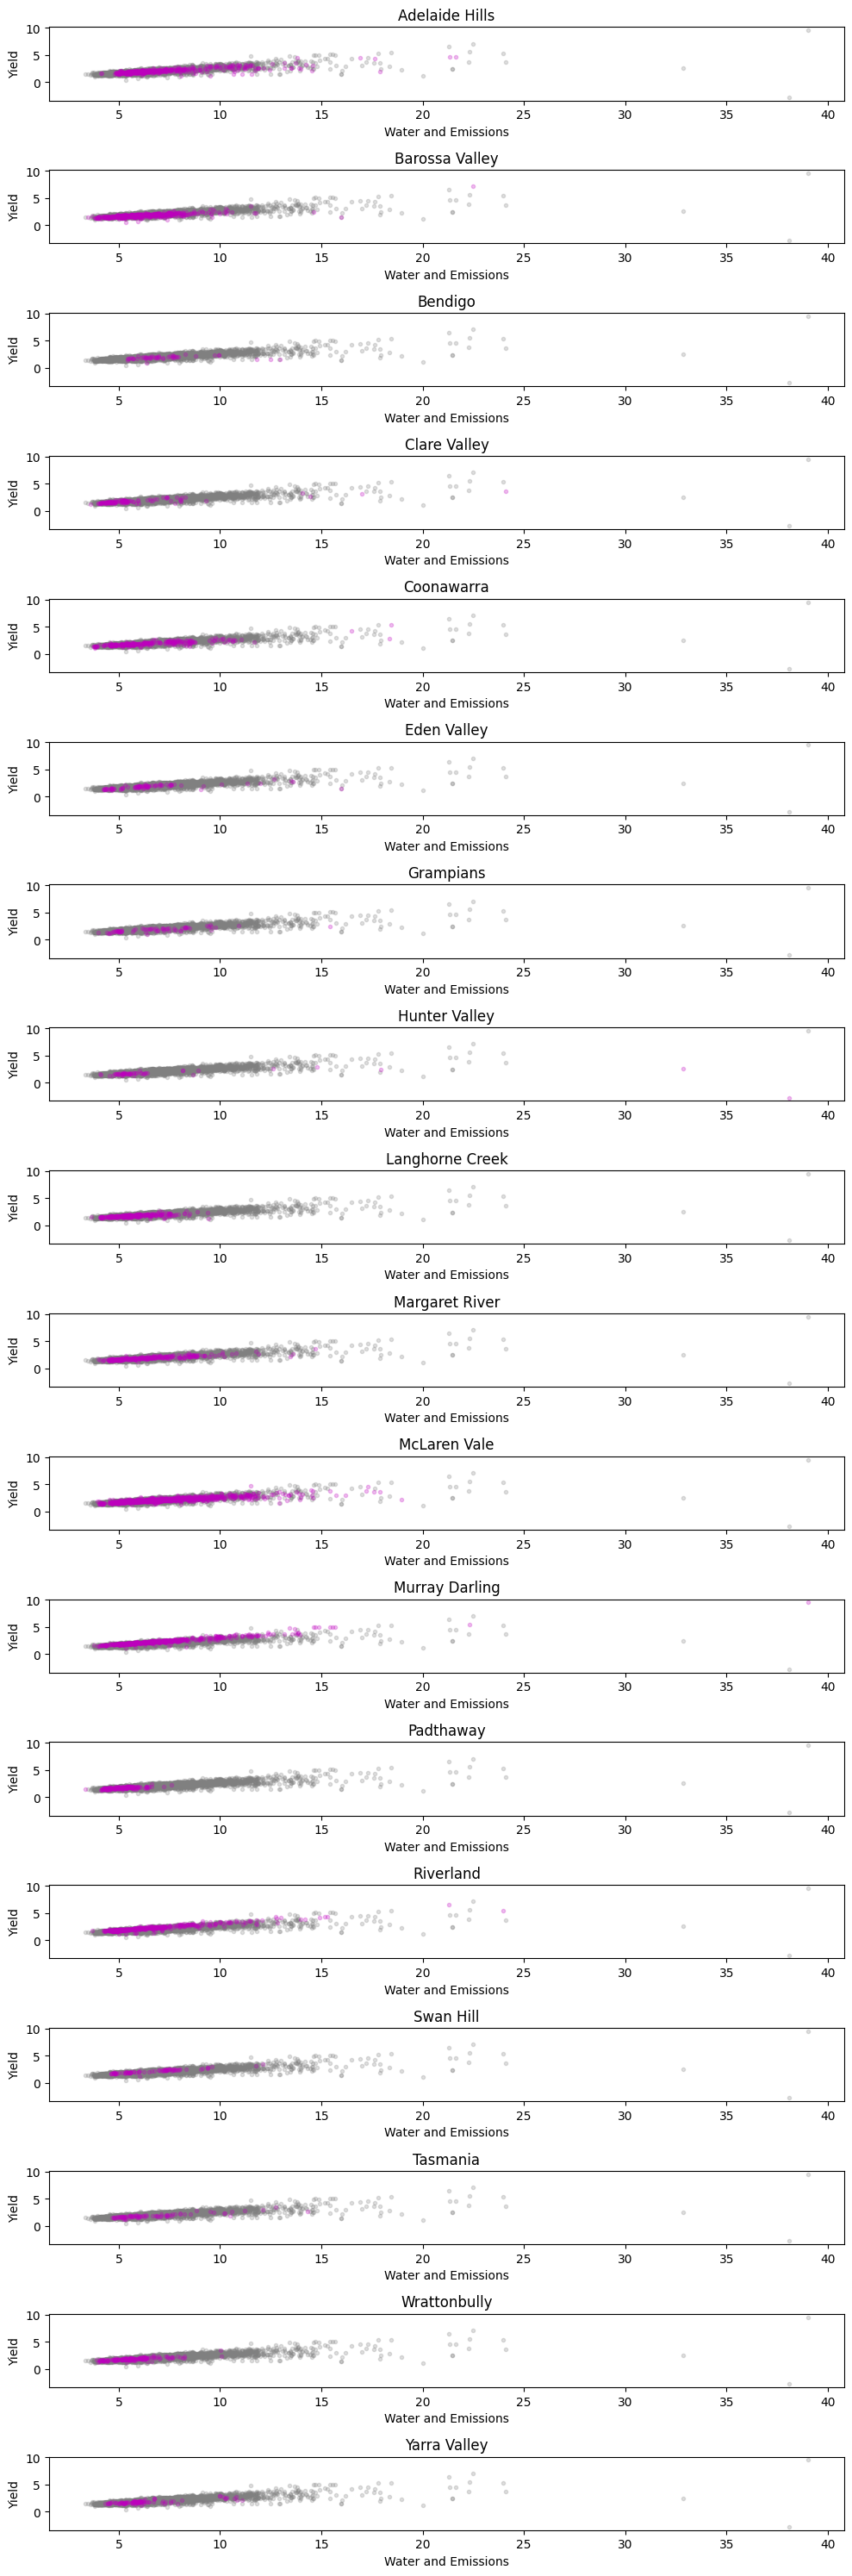

In [39]:
fig, ax = plt.subplots(len(region_selection), 1,  figsize=(10, 30))
i=0

for region in region_selection:
    axscatter = ax[i].scatter(df.loc[df["giregion"]!=region, "water_and_emmissions"]
        , (1+df.loc[df["giregion"]!=region, 'tonnes_grapes_harvested'].apply(np.log)).div((1+df.loc[df["giregion"]!=region, "area_harvested"]).apply(np.log))
        , color="gray"
        , alpha= 0.25
        , label="Other"
        , marker= "."
    )
    scatter = ax[i].scatter(
        df.loc[df["giregion"]==region, "water_and_emmissions"]
        , (1+df.loc[df["giregion"]==region, 'tonnes_grapes_harvested'].apply(np.log)).div((1+df.loc[df["giregion"]==region, "area_harvested"]).apply(np.log))
        , color="m"
        , alpha=0.25
        , label=region
        , marker= "."
    )
    ax[i].set_title(region)
    ax[i].set_xlabel("Water and Emissions")
    ax[i].set_ylabel('Yield')
    
    i += 1

#markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in region_color.values()]
#plt.legend(markers, region_selection, loc='lower center', bbox_to_anchor=(0.5, -.3), ncol=6)
fig.tight_layout()
plt.show()

### Finances

In [40]:
df.groupby("giregion")["average_per_tonne"].describe()

count         mean          std     min      25%  \
giregion                                                                     
0                           2.0  1325.000000   388.908730  1050.0  1187.50   
Adelaide Hills             60.0  1878.683333   380.167960  1025.0  1703.75   
Adelaide Plains             5.0  1227.000000   191.428838   935.0  1200.00   
Alpine Valleys              2.0  1125.000000   247.487373   950.0  1037.50   
Barossa Valley             95.0  2836.252632  1363.352103   757.0  2050.00   
Barossa Zone                3.0  2043.333333   487.476495  1530.0  1815.00   
Beechworth                  1.0  2600.000000          NaN  2600.0  2600.00   
Bendigo                    13.0  1503.230769   417.431462   750.0  1400.00   
Big Rivers Zone Other       0.0          NaN          NaN     NaN      NaN   
Blackwood Valley            2.0  1125.000000   318.198052   900.0  1012.50   
Canberra District           5.0  2176.000000   599.691587  1500.0  1800.00   
Clare Valley               22.0  1941.909091   701.918386  1129.0  1461.25   
Coonawarra                 38.0  2124.826316   818.951363  1100.0  1593.25   
Cowra                       0.0          NaN          NaN     NaN      NaN   
Currency Creek              4.0  1554.500000   472.737771  1018.0  1229.50   
Eden Valley                27.0  2084.074074   445.862425  1214.0  1779.50   
Geelong                     0.0          NaN          NaN     NaN      NaN   
Geographe                   0.0          NaN          NaN     NaN      NaN   
Glenrowan                   0.0          NaN          NaN     NaN      NaN   
Goulburn Valley             1.0  1113.000000          NaN  1113.0  1113.00   
Grampians                   5.0  1830.000000   449.444101  1300.0  1450.00   
Great Southern              3.0  2067.166667  1033.251704  1350.0  1475.00   
Gundagai                    1.0   850.000000          NaN   850.0   850.00   
Heathcote                   2.0  1100.000000    70.710678  1050.0  1075.00   
Henty                       0.0          NaN          NaN     NaN      NaN   
Hunter Valley               2.0  1862.500000   265.165043  1675.0  1768.75   
Kangaroo Island             1.0  1300.000000          NaN  1300.0  1300.00   
King Valley                 8.0  1018.755000   113.667347   880.0   937.50   
Langhorne Creek            45.0  1062.502667   370.529436   525.0   832.00   
Macedon Ranges              1.0  3494.000000          NaN  3494.0  3494.00   
Margaret River             46.0  1773.099565   556.838382  1100.0  1381.25   
McLaren Vale              214.0  2368.861121  1753.029360   545.0  1800.00   
Mornington Peninsula        3.0  2833.333333   404.145188  2600.0  2600.00   
Mount Benson                1.0  1600.000000          NaN  1600.0  1600.00   
Mount Gambier               1.0  1600.000000          NaN  1600.0  1600.00   
Mudgee                      6.0  1850.000000   126.491106  1700.0  1762.50   
Murray Darling             62.0   489.309032   174.324358   160.0   398.50   
Orange                     18.0  1637.666667   620.962062   260.0  1269.75   
Other                       3.0  1186.666667  1137.555859   510.0   530.00   
Padthaway                  20.0  1581.235000   712.711361   830.0  1093.75   
Pemberton                   5.0  1429.400000   250.523053  1200.0  1200.00   
Pyrenees                    0.0          NaN          NaN     NaN      NaN   
Riverina                    0.0          NaN          NaN     NaN      NaN   
Riverland                  82.0   536.944268   192.420887   253.0   430.75   
Robe                        1.0  1200.000000          NaN  1200.0  1200.00   
Rutherglen                  9.0  1315.333333   568.540236   700.0  1015.00   
Southern Fleurieu           4.0  1088.000000   130.802650   952.0   988.00   
Southern Flinders Ranges    1.0   838.000000          NaN   838.0   838.00   
Southern Highlands          0.0          NaN          NaN     NaN      NaN   
Strathbogie Ranges          2.0  1400.000000   1

In [42]:
rpy2.ipython.html.init_printing()
r = robjects.r
#feature_list.append("average_per_tonne")

from data import mean_sale_price

avg_prices = df[
    df["average_per_tonne"].isnull()].apply(
    lambda x: mean_sale_price(x["giregion"],
                              x["data_year_id"]),
    axis=1)
df["average_per_tonne"] = df["average_per_tonne"].replace({0: np.nan})
df["average_per_tonne"] = df["average_per_tonne"].combine_first(avg_prices)

dfr = df.loc[df[df["average_per_tonne"]!=0].index, feature_list].copy()
dfr["average_per_tonne"] = df.loc[df[df["average_per_tonne"]!=0].index, "average_per_tonne"]

dfr.to_csv("data.csv")

r.source("linear_model.r")

model = r.linear_model("data.csv", "(log(df$average_per_tonne*(1+df$tonnes_grapes_harvested)))/log(df$area_harvested+1)"
    "~ log(df$total_emissions+1)/log(df$area_harvested+1) "
    "+ log(df$water_used+1)/log(df$area_harvested+1) "
)


***************
*    ANOVA    *

Analysis of Deviance Table

Model: gaussian, link: identity

Response: (log(df$average_per_tonne * (1 + df$tonnes_grapes_harvested)))/log(df$area_harvested + 1)

Terms added sequentially (first to last)


                                                       Df Deviance Resid. Df
NULL                                                                    2910
log(df$total_emissions + 1)                             1   3201.5      2909
log(df$water_used + 1)                                  1    213.9      2908
log(df$total_emissions + 1):log(df$area_harvested + 1)  1    508.1      2907
log(df$area_harvested + 1):log(df$water_used + 1)       1    654.3      2906
                                                       Resid. Dev
NULL                                                       5859.5
log(df$total_emissions + 1)                                2658.0
log(df$water_used + 1)                                     2444.1
log(df$total_emissions + 1):log(df$

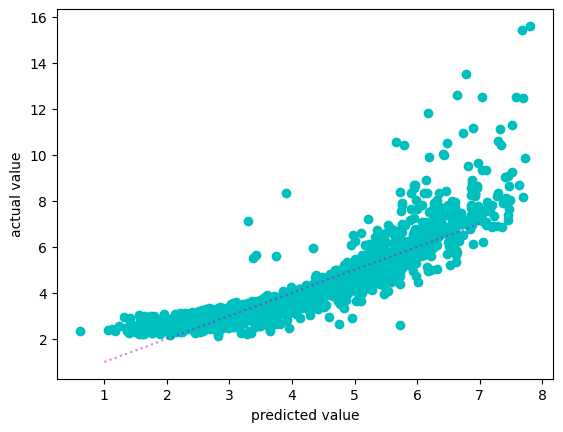

In [43]:
fig, ax = plt.subplots()

plt.plot([1,7], [1,7], color='m', linestyle='dotted', alpha=0.5)
plt.scatter(model[2]
    , model[17]
    , color="c")

plt.xlabel("predicted value")
plt.ylabel("actual value")

plt.show()    

(array([1.000e+00, 0.000e+00, 1.500e+01, 8.400e+01, 3.250e+02, 2.932e+03,
        1.800e+03, 1.770e+02, 4.100e+01, 9.000e+00, 3.000e+00, 1.100e+01,
        0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([-2.09142314, -1.73408908, -1.37675502, -1.01942096, -0.6620869 ,
        -0.30475284,  0.05258122,  0.40991527,  0.76724933,  1.12458339,
         1.48191745,  1.83925151,  2.19658557,  2.55391963,  2.91125369,
         3.26858775,  3.62592181,  3.98325587,  4.34058993,  4.69792399,
         5.05525805]),
 <BarContainer object of 20 artists>)

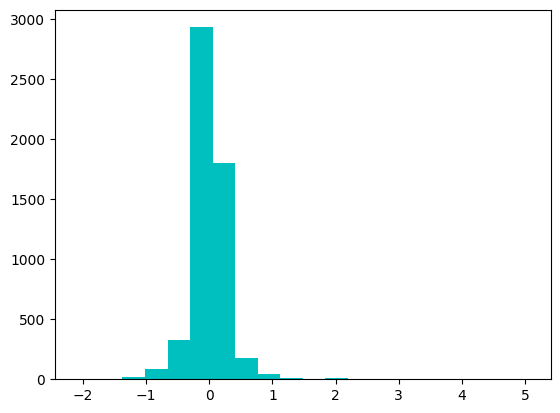

In [44]:
plt.hist(residuals, bins=20, color="c")

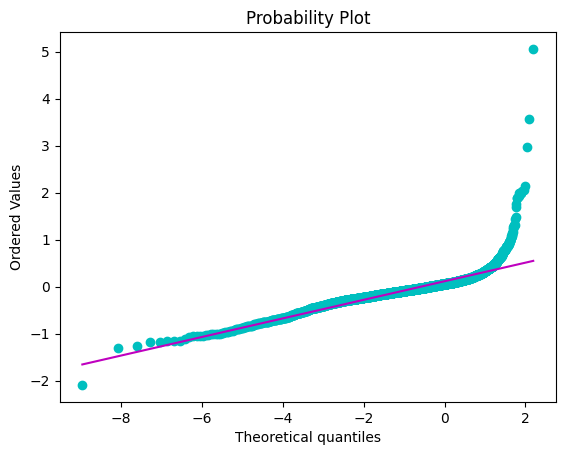

In [45]:
from scipy import stats


from scipy import stats



fig, ax = plt.subplots()

stats.probplot(
    residuals
    , dist=stats.loggamma
    , sparams=(1)
    , plot=ax
)

ax.get_lines()[0].set_color("c")
ax.get_lines()[1].set_color("m")

plt.show()    

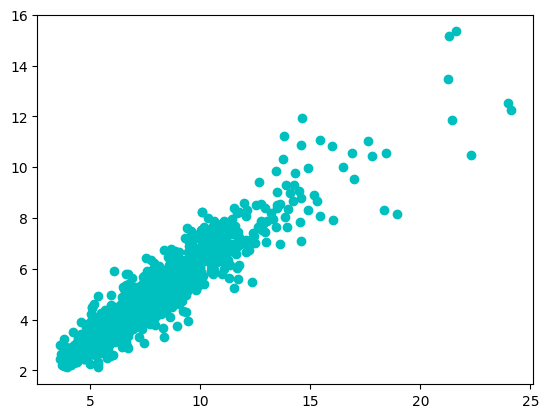

In [46]:
df["yield_avg"] = (1+(df['average_per_tonne']*df['tonnes_grapes_harvested'])).apply(np.log).div((1+df["area_harvested"]).apply(np.log))

plt.scatter(df["water_and_emmissions"], df["yield_avg"], color="c")

plt.show()

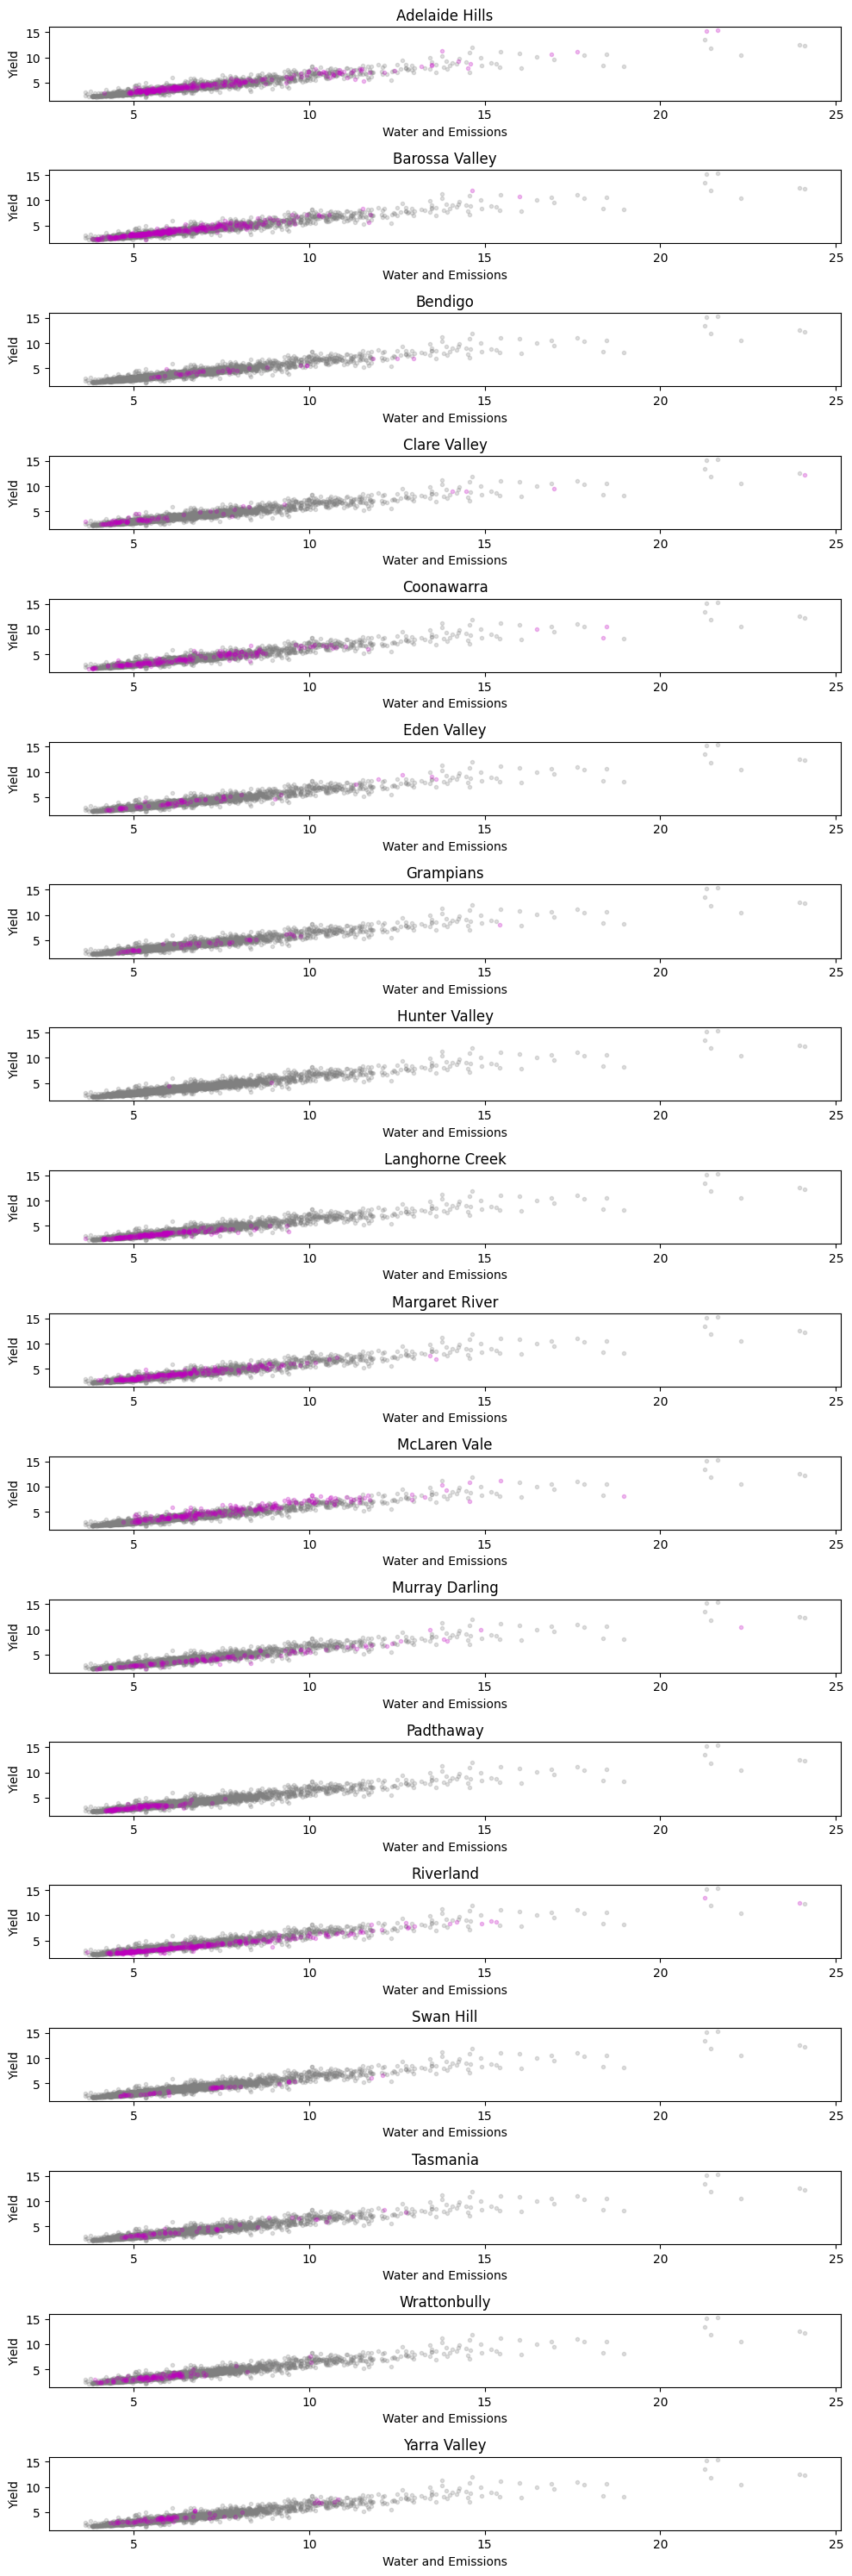

In [48]:
fig, ax = plt.subplots(len(region_selection), 1,  figsize=(10, 30))
i=0

for region in region_selection:
    axscatter = ax[i].scatter(df.loc[df["giregion"]!=region, "water_and_emmissions"]
        , df.loc[df["giregion"]!=region, 'yield_avg']
        , color="gray"
        , alpha= 0.25
        , label="Other"
        , marker= "."
    )
    scatter = ax[i].scatter(
        df.loc[df["giregion"]==region, "water_and_emmissions"]
        , df.loc[df["giregion"]==region, 'yield_avg']
        , color="m"
        , alpha=0.25
        , label=region
        , marker= "."
    )
    ax[i].set_title(region)
    ax[i].set_xlabel("Water and Emissions")
    ax[i].set_ylabel('Yield')
    
    i += 1

#markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in region_color.values()]
#plt.legend(markers, region_selection, loc='lower center', bbox_to_anchor=(0.5, -.3), ncol=6)
fig.tight_layout()
plt.show()

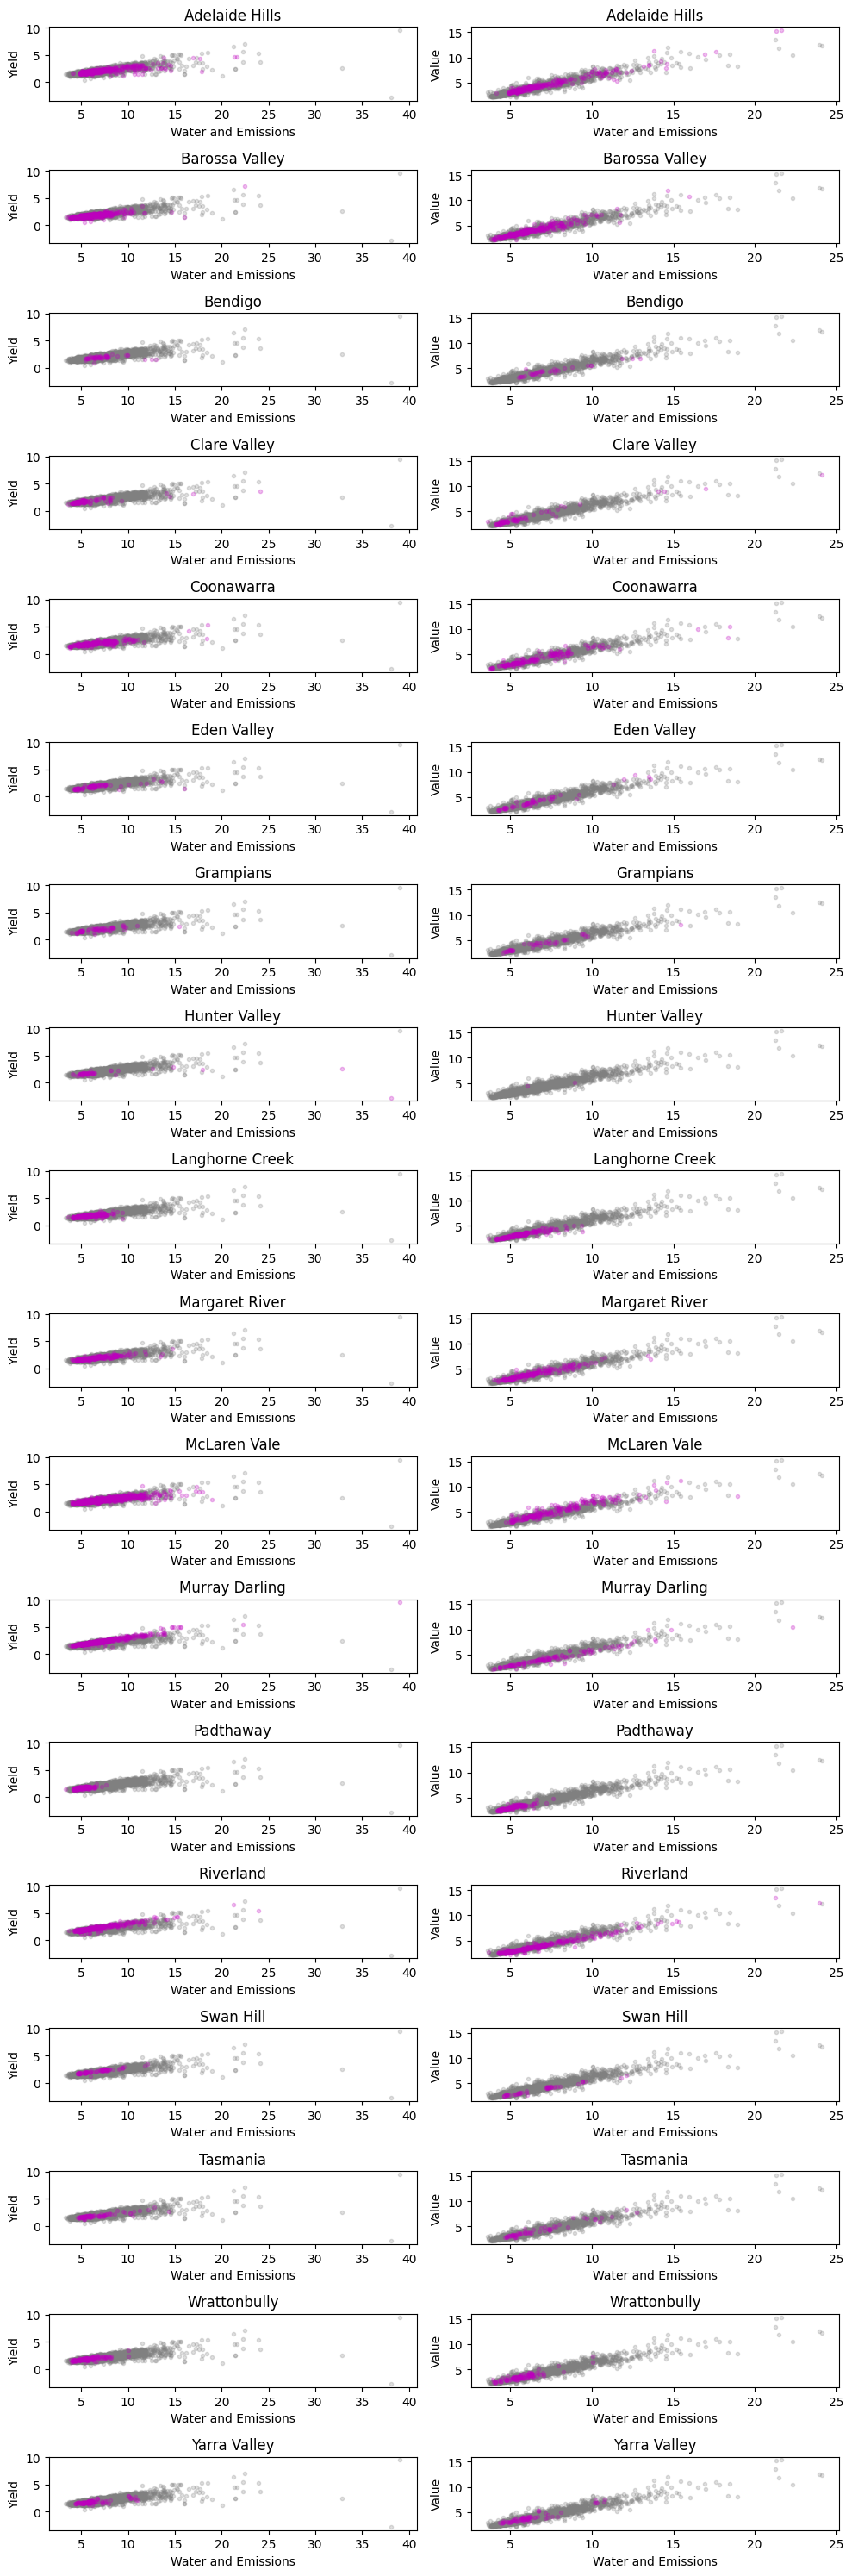

In [49]:
fig, ax = plt.subplots(len(region_selection), 2,  figsize=(10, 30))
i=0

for region in region_selection:
    axscatter = ax[i][0].scatter(df.loc[df["giregion"]!=region, "water_and_emmissions"]
        , (1+df.loc[df["giregion"]!=region, 'tonnes_grapes_harvested'].apply(np.log)).div((1+df.loc[df["giregion"]!=region, "area_harvested"]).apply(np.log))
        , color="gray"
        , alpha= 0.25
        , label="Other"
        , marker= "."
    )
    scatter = ax[i][0].scatter(
        df.loc[df["giregion"]==region, "water_and_emmissions"]
        , (1+df.loc[df["giregion"]==region, 'tonnes_grapes_harvested'].apply(np.log)).div((1+df.loc[df["giregion"]==region, "area_harvested"]).apply(np.log))
        , color="m"
        , alpha=0.25
        , label=region
        , marker= "."
    )
    ax[i][0].set_title(region)
    ax[i][0].set_xlabel("Water and Emissions")
    ax[i][0].set_ylabel('Yield')
    ##
    axscatter = ax[i][1].scatter(df.loc[df["giregion"]!=region, "water_and_emmissions"]
        , df.loc[df["giregion"]!=region, 'yield_avg']
        , color="gray"
        , alpha= 0.25
        , label="Other"
        , marker= "."
    )
    scatter = ax[i][1].scatter(
        df.loc[df["giregion"]==region, "water_and_emmissions"]
        , df.loc[df["giregion"]==region, 'yield_avg']
        , color="m"
        , alpha=0.25
        , label=region
        , marker= "."
    )
    ax[i][1].set_title(region)
    ax[i][1].set_xlabel("Water and Emissions")
    ax[i][1].set_ylabel('Value')
    i += 1

#markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in region_color.values()]
#plt.legend(markers, region_selection, loc='lower center', bbox_to_anchor=(0.5, -.3), ncol=6)
fig.tight_layout()
plt.show()

# CARTS

In [50]:
feature_list

['area_harvested',
 'tonnes_grapes_harvested',
 'water_used',
 'total_tractor_passes',
 'slashing_number_of_times_passes_per_year',
 'fungicide_spraying_number_of_times_passes_per_year',
 'herbicide_spraying_number_of_times_passes_per_year',
 'insecticide_spraying_number_of_times_passes_per_year',
 'fertiliser',
 'total_emissions']

### Regional Climates

In [51]:
df["rain"] = df["giregion"].apply(rain)
df["temp"] = df["giregion"].apply(temp)
df.loc[df["rain"]=="Unknown Climate", "rain"] = np.nan
df.loc[df["temp"]=="Unknown Climate", "temp"] = np.nan
df["climate"] = df["temp"] + " " + df["rain"]
df.loc[df["climate"]=="Unknown Climate Unknown Climate", "climate"] = np.nan

In [52]:
df["climate"].unique()

array(['Warm Very Dry', 'Mild Dry', 'Hot Damp', 'Cool Dry', 'Warm Dry',
       'Hot Very Dry', 'Cool Damp', 'Mild Very Dry', 'Warm Damp', nan,
       'Mild Damp', 'Cool Very Dry'], dtype=object)

<AxesSubplot: >

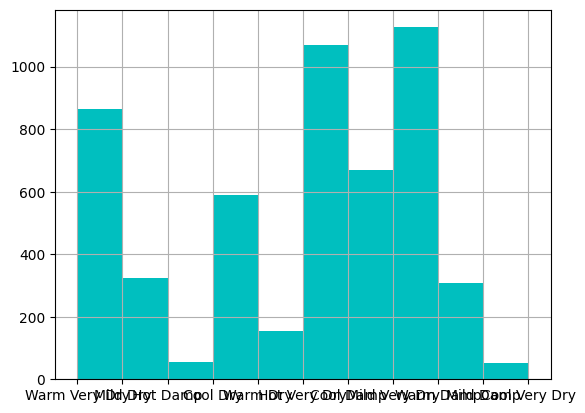

In [53]:
df["climate"].hist(color="c")

<AxesSubplot: >

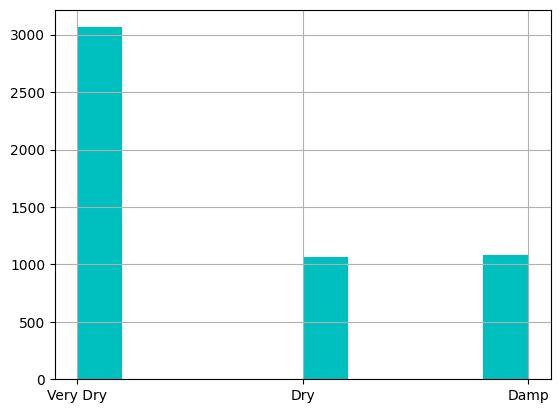

In [54]:
df["rain"].hist(color="c")

<AxesSubplot: >

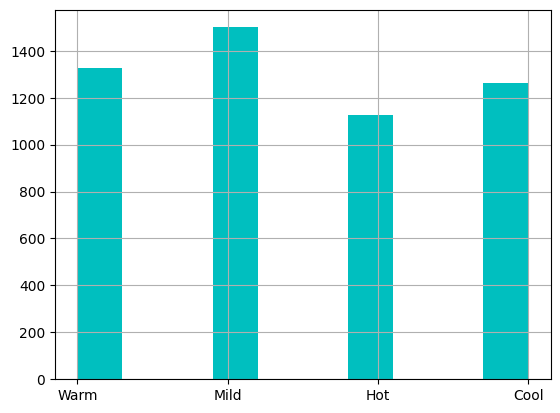

In [55]:
df["temp"].hist(color="c")

In [56]:
df["yield/ha"] = df["tonnes_grapes_harvested"].div(df["area_harvested"])
df["yield*avg/ha"] = df["tonnes_grapes_harvested"]*df["average_per_tonne"]
df["yield*avg/ha"] = df["yield*avg/ha"].div(df["area_harvested"])

class_features = feature_list
class_features.append("giregion")
class_features.append("yield/ha")
class_features.append("yield*avg/ha")
class_features.append("rain")
class_features.append("temp")
class_features.append("climate")

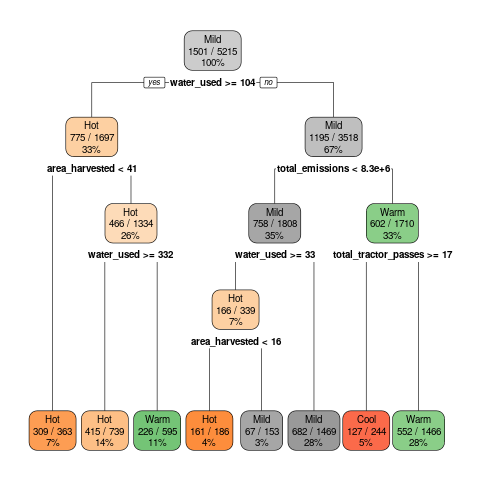

In [57]:
from IPython import display
display.Image(filename=".tree.png")

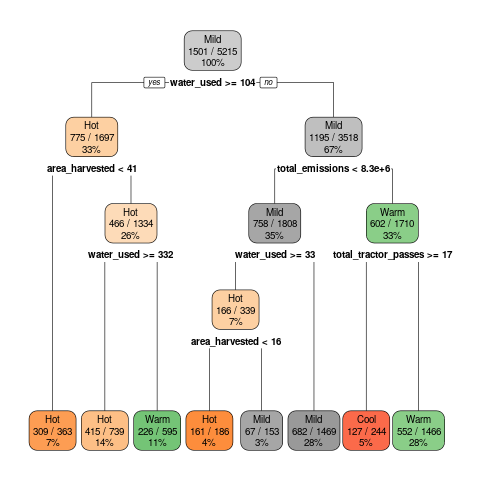

In [58]:
from IPython import display
display.Image(filename=".tree.png")

In [59]:
palette=[
        "#009292",
        "#ff6db6",
        "#490092",
        "#b66dff",
        "#6db6ff",
        "#b6dbff",
        "#920000",
        "#db6d00",
        "#24ff24",
        "#ffff6d",
        "#006ddb",
        "#000000",
        "#004949",
        "#ffb6db",
        "#924900",
    ]

import matplotlib.cm as cm

climate_color = {}
color = iter(palette)

climate_selection = df["climate"].unique()

for i in range(len(climate_selection)):
   climate_color[climate_selection[i]] = i = next(color)

df['clim_colors'] = df.loc[df["climate"].notnull(), "climate"].apply(lambda x: climate_color[x])

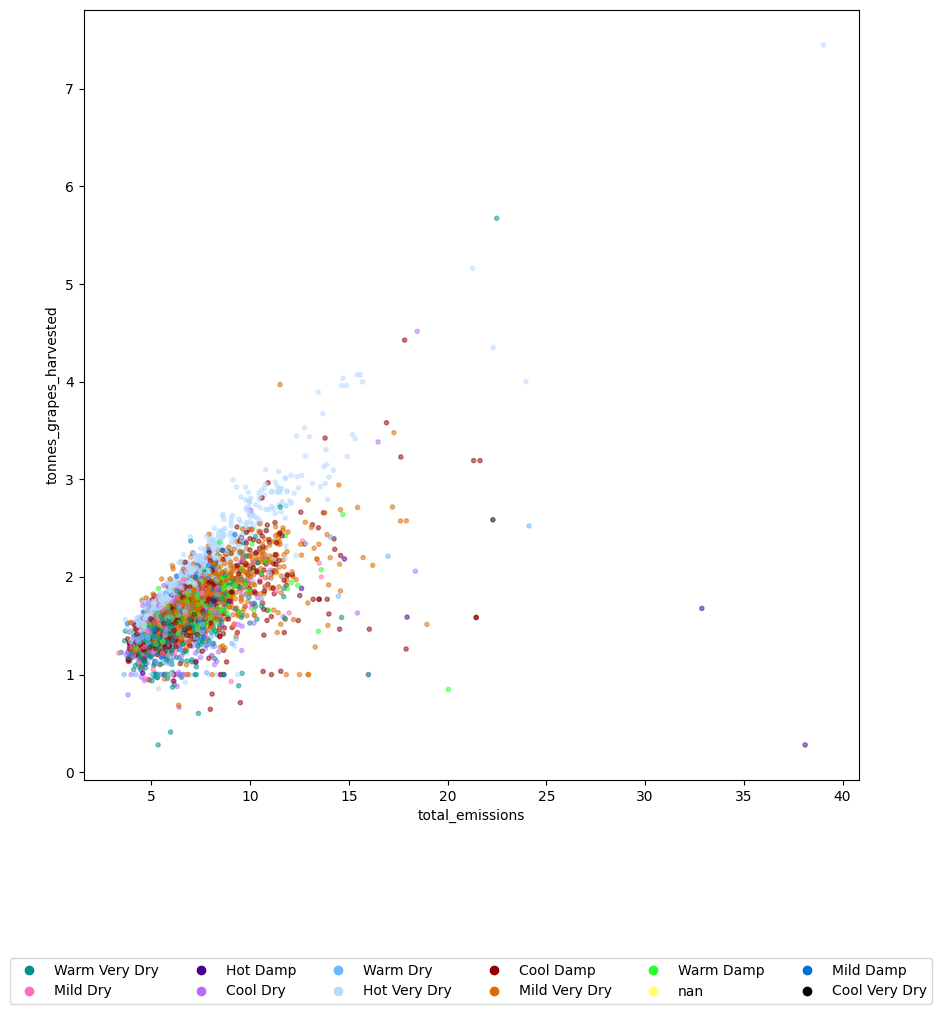

In [60]:
fig, ax = plt.subplots(figsize=(10, 10))

scatter = ax.scatter(
    df.loc[df["climate"].notnull(),"water_and_emmissions"],
    df.loc[df["climate"].notnull(),'yield'],
    c=df.loc[df["climate"].notnull(),"clim_colors"]
    , label=df.loc[df["climate"].notnull(),"climate"]
    , marker= "."
    , alpha=0.5
)
ax.set_xlabel(feature)
ax.set_ylabel('tonnes_grapes_harvested')
ax.set(xlabel=feature, ylabel='tonnes_grapes_harvested')

markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in climate_color.values()]
plt.legend(markers, climate_selection, loc='lower center', bbox_to_anchor=(0.5, -.3), ncol=6)

plt.show()

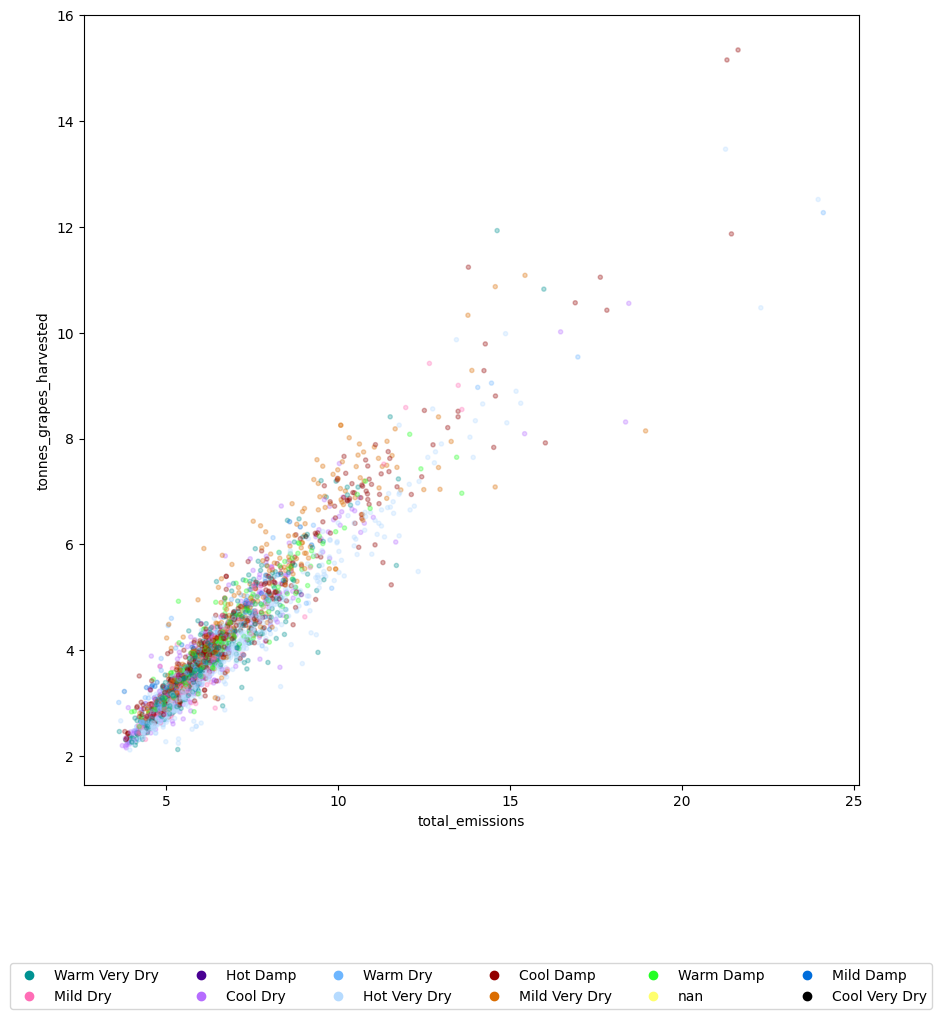

In [61]:
fig, ax = plt.subplots(figsize=(10, 10))

scatter = ax.scatter(
    df.loc[df["climate"].notnull(),"water_and_emmissions"],
    df.loc[df["climate"].notnull(),'yield_avg'],
    c=df.loc[df["climate"].notnull(),"clim_colors"]
    , label=df.loc[df["climate"].notnull(),"climate"]
    , marker= "."
    , alpha=0.3
)
ax.set_xlabel(feature)
ax.set_ylabel('tonnes_grapes_harvested')
ax.set(xlabel=feature, ylabel='tonnes_grapes_harvested')


markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in climate_color.values()]
plt.legend(markers, climate_selection, loc='lower center', bbox_to_anchor=(0.5, -.3), ncol=6)

    
plt.show()

In [62]:
import matplotlib.cm as cm

rain_color = {}
color = iter(palette)

rain_selection = df.loc[df["climate"].notnull(), "rain"].unique()

for i in range(len(rain_selection)):
   rain_color[rain_selection[i]] = i = next(color)

df['rain_colors'] = df.loc[df["climate"].notnull(),"rain"].apply(lambda x: rain_color[x])

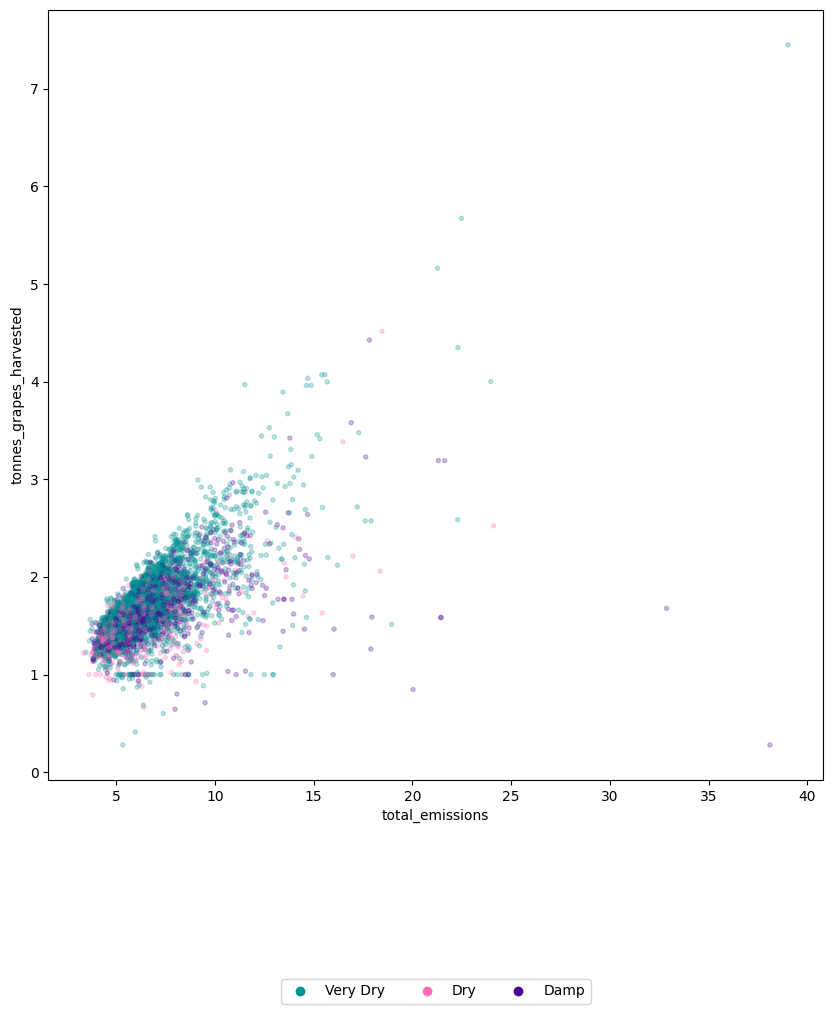

In [63]:
fig, ax = plt.subplots(figsize=(10, 10))

scatter = ax.scatter(
    df.loc[df["climate"].notnull(), "water_and_emmissions"],
    df.loc[df["climate"].notnull(), 'yield'],
    c=df.loc[df["climate"].notnull(), "rain_colors"]
    , label=df.loc[df["climate"].notnull(), "rain"]
    , marker= "."
    , alpha=0.25
)
ax.set_xlabel(feature)
ax.set_ylabel('tonnes_grapes_harvested')
ax.set(xlabel=feature, ylabel='tonnes_grapes_harvested')

markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in rain_color.values()]
plt.legend(markers, rain_selection, loc='lower center', bbox_to_anchor=(0.5, -.3), ncol=6)

plt.show()

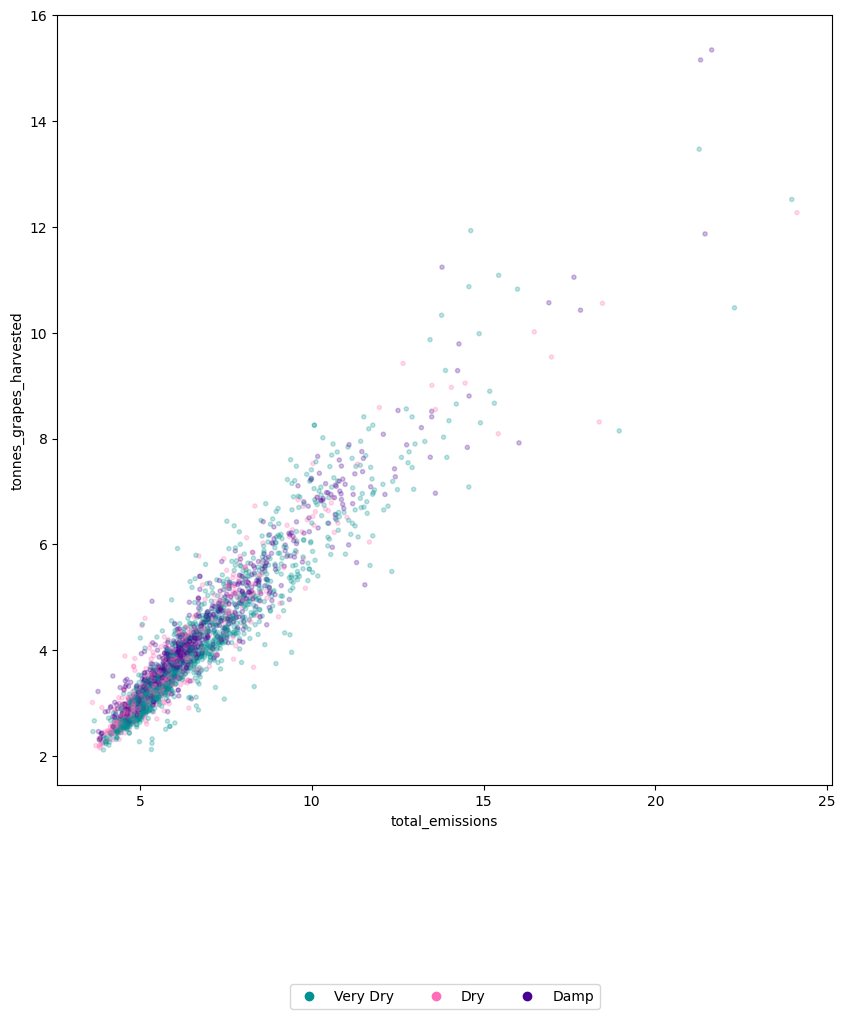

In [64]:
fig, ax = plt.subplots(figsize=(10, 10))

scatter = ax.scatter(
    df.loc[df["climate"].notnull(), "water_and_emmissions"],
    df.loc[df["climate"].notnull(), 'yield_avg'],
    c=df.loc[df["climate"].notnull(), "rain_colors"]
    , label=df.loc[df["climate"].notnull(), "rain"]
    , marker= "."
    , alpha=0.25
)
ax.set_xlabel(feature)
ax.set_ylabel('tonnes_grapes_harvested * average grape price')
ax.set(xlabel=feature, ylabel='tonnes_grapes_harvested')

markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in rain_color.values()]
plt.legend(markers, rain_selection, loc='lower center', bbox_to_anchor=(0.5, -.3), ncol=6)

plt.show()

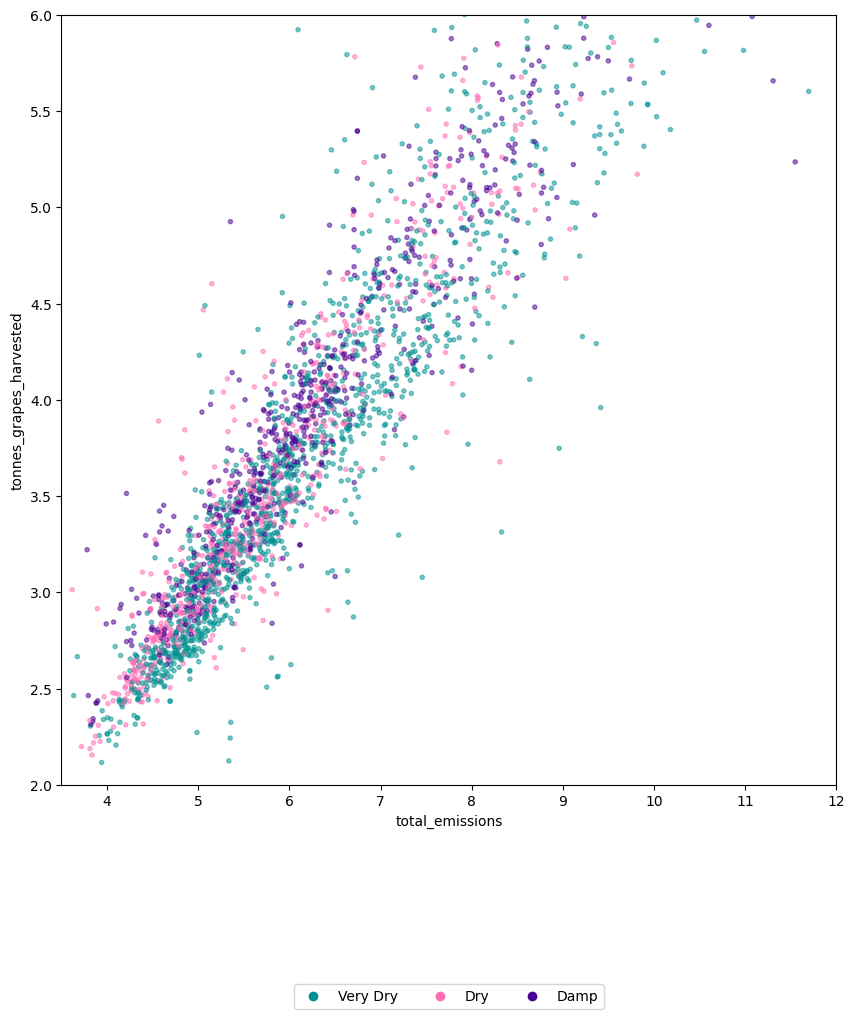

In [65]:
fig, ax = plt.subplots(figsize=(10, 10))
rain_map = {'Very Dry': "brown", 'Damp': "blue", 'Dry': "brown", 'Unknown Climate': None}

scatter = ax.scatter(
    df.loc[df["climate"].notnull(), "water_and_emmissions"],
    df.loc[df["climate"].notnull(), 'yield_avg'],
    c=df.loc[df["climate"].notnull(), "rain_colors"]
    , label=df.loc[df["climate"].notnull(), "rain"]
    , marker= "."
    , alpha=.5
)
ax.set_xlabel(feature)
ax.set_ylabel('tonnes_grapes_harvested * average grape price')
ax.set(xlabel=feature, ylabel='tonnes_grapes_harvested')
ax.set_xlim([3.5,12])
ax.set_ylim([2,6])

markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in rain_color.values()]
plt.legend(markers, rain_selection, loc='lower center', bbox_to_anchor=(0.5, -.3), ncol=6)

plt.show()

In [66]:
temp_selection = df.groupby("temp").count()[(df.groupby("temp").count()>50)["member_id"]].index.values

import matplotlib.cm as cm

temp_color = {}
color = iter(palette)
temp_selection = df.loc[df["climate"].notnull(), "temp"].unique()

for i in range(len(temp_selection)):
   temp_color[temp_selection[i]] = i = next(color)

df['temp_colors'] = df.loc[df["climate"].notnull(), "temp"].apply(lambda x: temp_color[x])

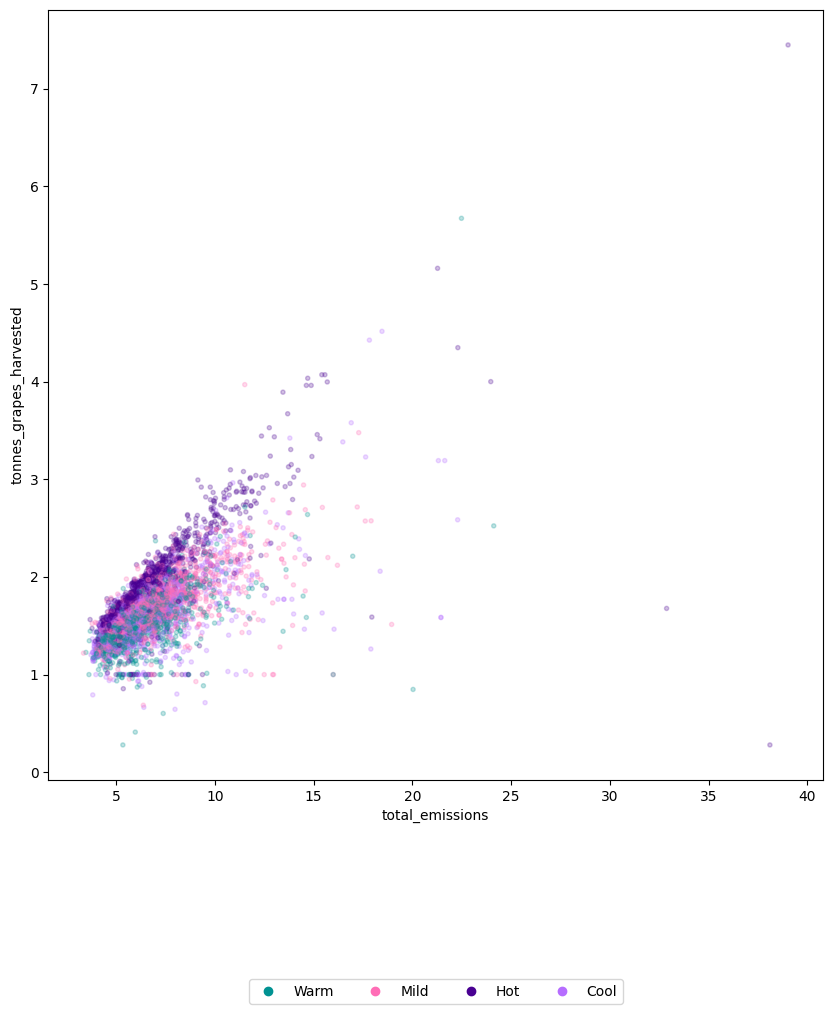

In [67]:
fig, ax = plt.subplots(figsize=(10, 10))

scatter = ax.scatter(
    df.loc[df["climate"].notnull(), "water_and_emmissions"],
    df.loc[df["climate"].notnull(), 'yield'],
    c=df.loc[df["climate"].notnull(), "temp_colors"]
    , label=df.loc[df["climate"].notnull(), "temp"]
    , marker= "."
    , alpha=0.25
)
ax.set_xlabel(feature)
ax.set_ylabel('tonnes_grapes_harvested')
ax.set(xlabel=feature, ylabel='tonnes_grapes_harvested')

markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in temp_color.values()]
plt.legend(markers, temp_selection, loc='lower center', bbox_to_anchor=(0.5, -.3), ncol=6)

plt.show()

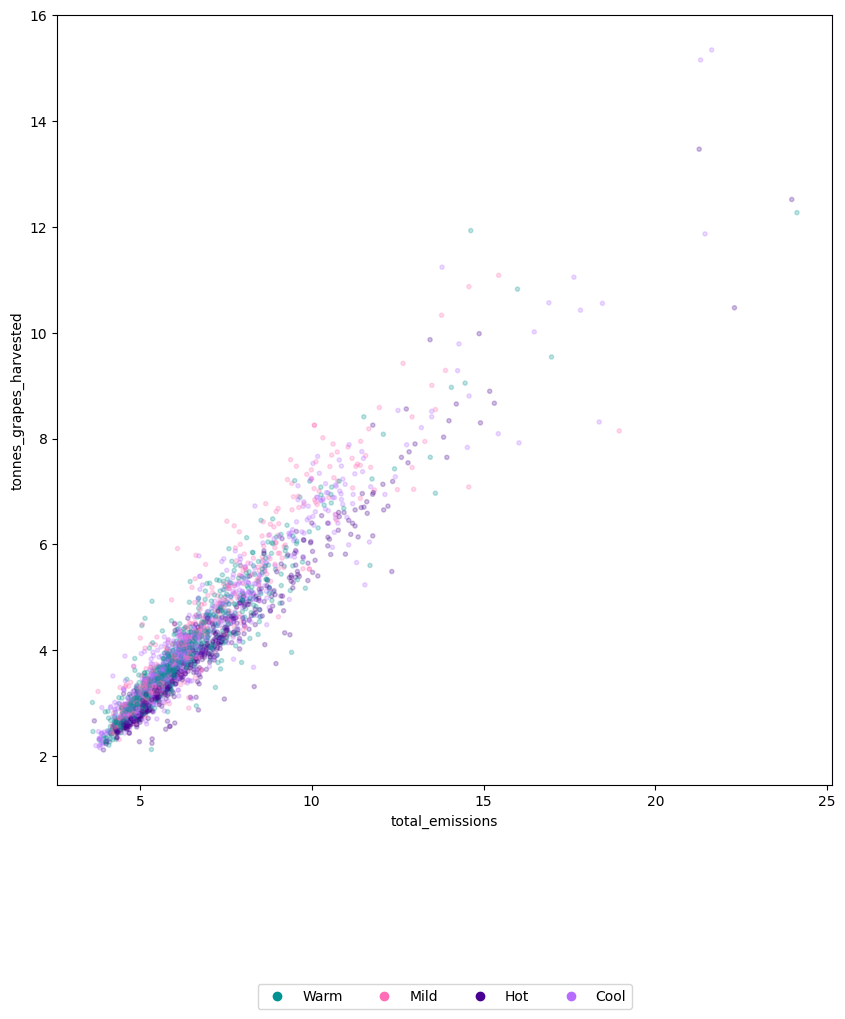

In [68]:
fig, ax = plt.subplots(figsize=(10, 10))

scatter = ax.scatter(
    df.loc[df["climate"].notnull(), "water_and_emmissions"],
    df.loc[df["climate"].notnull(), 'yield_avg'],
    c=df.loc[df["climate"].notnull(), "temp_colors"]
    , label=df.loc[df["climate"].notnull(), "temp"]
    , marker= "."
    , alpha=0.25
)
ax.set_xlabel(feature)
ax.set_ylabel('tonnes_grapes_harvested')
ax.set(xlabel=feature, ylabel='tonnes_grapes_harvested')

markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in temp_color.values()]
plt.legend(markers, temp_selection, loc='lower center', bbox_to_anchor=(0.5, -.3), ncol=6)

plt.show()

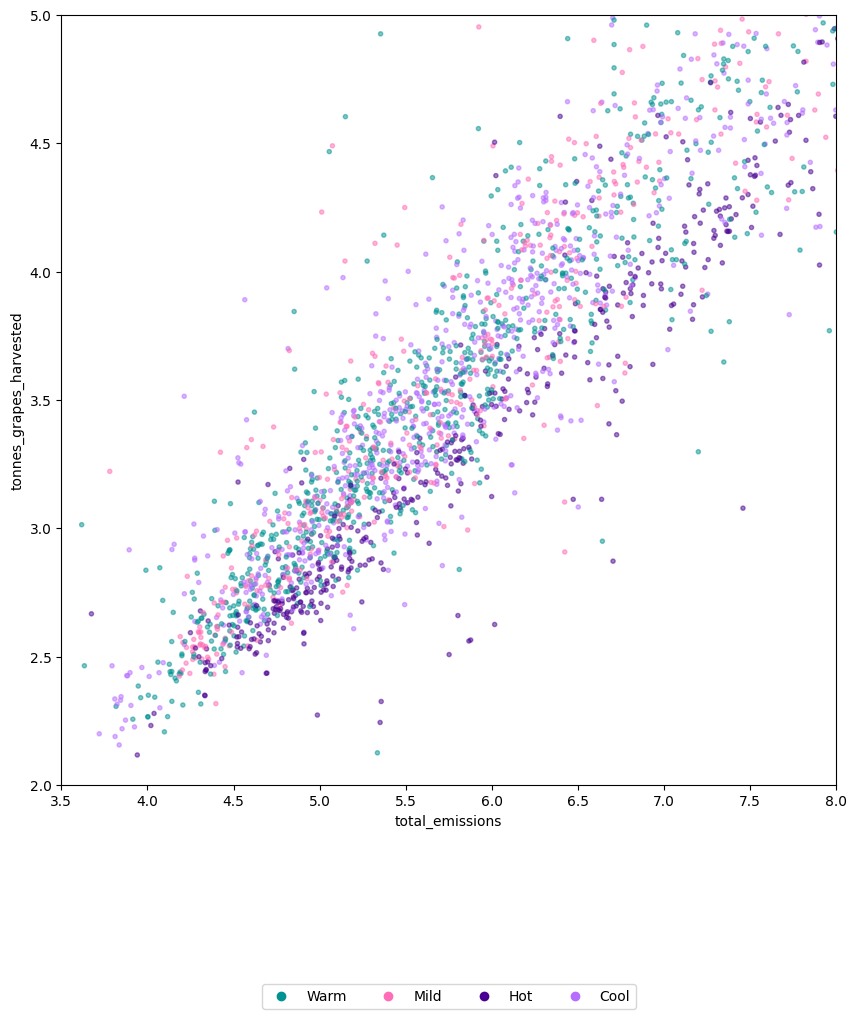

In [69]:
fig, ax = plt.subplots(figsize=(10, 10))

scatter = ax.scatter(
    df.loc[df["climate"].notnull(), "water_and_emmissions"],
    df.loc[df["climate"].notnull(), 'yield_avg'],
    c=df.loc[df["climate"].notnull(), "temp_colors"]
    , label=df.loc[df["climate"].notnull(), "temp"]
    , marker= "."
    , alpha=0.5
)
ax.set_xlabel(feature)
ax.set_ylabel('tonnes_grapes_harvested')
ax.set(xlabel=feature, ylabel='tonnes_grapes_harvested')

ax.set_xlim([3.5,8])
ax.set_ylim([2,5])

markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in temp_color.values()]
plt.legend(markers, temp_selection, loc='lower center', bbox_to_anchor=(0.5, -.3), ncol=6)

plt.show()

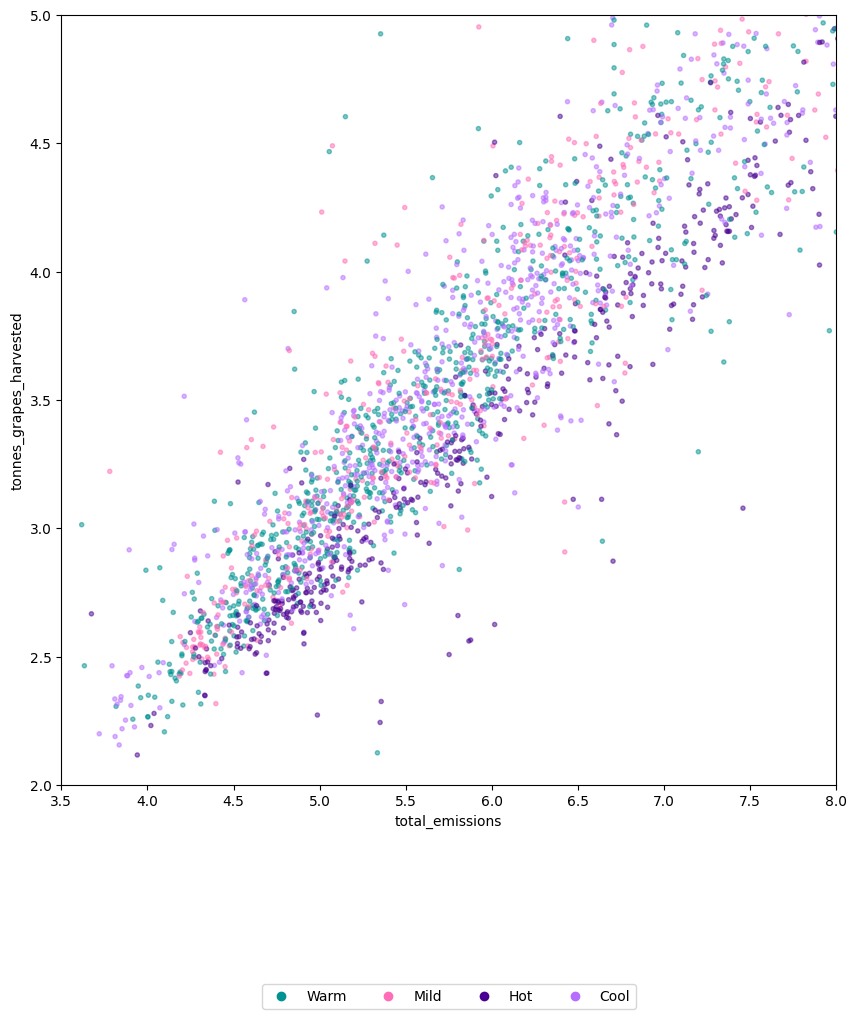

In [70]:
fig, ax = plt.subplots(figsize=(10, 10))

scatter = ax.scatter(
    df.loc[df["climate"].notnull(), "water_and_emmissions"],
    df.loc[df["climate"].notnull(), 'yield_avg'],
    c=df.loc[df["climate"].notnull(), "temp_colors"]
    , label=df.loc[df["climate"].notnull(), "temp"]
    , marker= "."
    , alpha=0.5
)
ax.set_xlabel(feature)
ax.set_ylabel('tonnes_grapes_harvested')
ax.set(xlabel=feature, ylabel='tonnes_grapes_harvested')

ax.set_xlim([3.5,8])
ax.set_ylim([2,5])

markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in temp_color.values()]
plt.legend(markers, temp_selection, loc='lower center', bbox_to_anchor=(0.5, -.3), ncol=6)

plt.show()

In [71]:
df["use_contractors"] = df['slashing_number_of_times_passes_per_year'].replace({np.nan: 0}) +\
       df['fungicide_spraying_number_of_times_passes_per_year'].replace({np.nan: 0}) +\
       df['herbicide_spraying_number_of_times_passes_per_year'].replace({np.nan: 0}) +\
       df['insecticide_spraying_number_of_times_passes_per_year'].replace({np.nan: 0})
df.loc[df["use_contractors"] > 0, "use_contractors"] = 1
df["use_contractors"] = df["use_contractors"].map({0: "No Contractors", 1: "Used Contractors"})
df["use_contractors"]

0         No Contractors
1         No Contractors
2         No Contractors
3         No Contractors
4         No Contractors
              ...       
6078    Used Contractors
6079    Used Contractors
6081    Used Contractors
6082    Used Contractors
6087    Used Contractors
Name: use_contractors, Length: 5401, dtype: object

In [72]:
df["use_contractors"]

0         No Contractors
1         No Contractors
2         No Contractors
3         No Contractors
4         No Contractors
              ...       
6078    Used Contractors
6079    Used Contractors
6081    Used Contractors
6082    Used Contractors
6087    Used Contractors
Name: use_contractors, Length: 5401, dtype: object

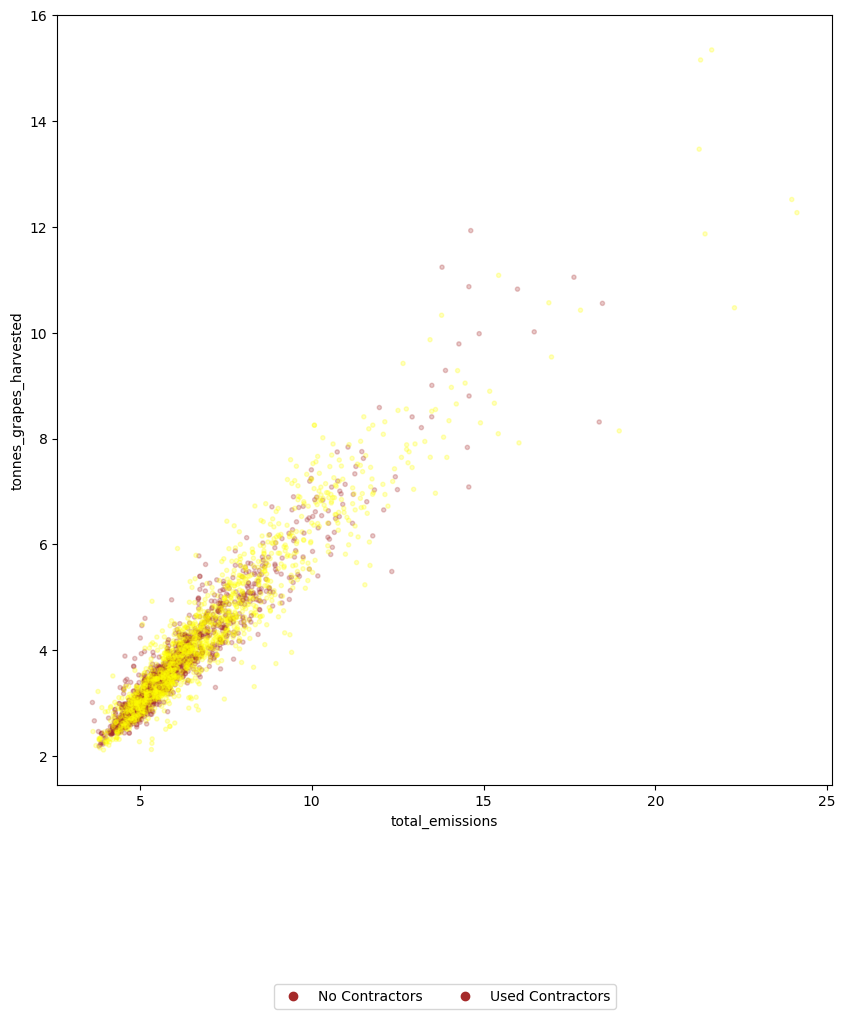

In [73]:
fig, ax = plt.subplots(figsize=(10, 10))

colors = {"No Contractors": "brown", "Used Contractors": "yellow"}

scatter = ax.scatter(
    df["water_and_emmissions"],
    df['yield_avg']
    , c=df["use_contractors"].map(colors)
    , label=df["use_contractors"]
    , marker= "."
    , alpha=0.25
)
ax.set_xlabel(feature)
ax.set_ylabel('tonnes_grapes_harvested')
ax.set(xlabel=feature, ylabel='tonnes_grapes_harvested')

markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in df["use_contractors"].map(colors).values]
plt.legend(markers, df["use_contractors"].unique(), loc='lower center', bbox_to_anchor=(0.5, -.3), ncol=6)

plt.show()

<AxesSubplot: >

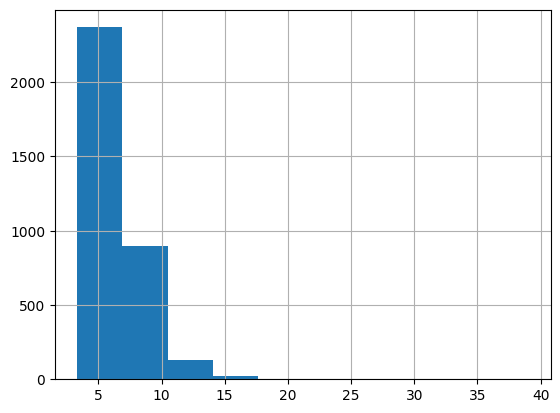

In [76]:
df[df["use_contractors"]=="No Contractors"]["water_and_emmissions"].hist()

<AxesSubplot: >

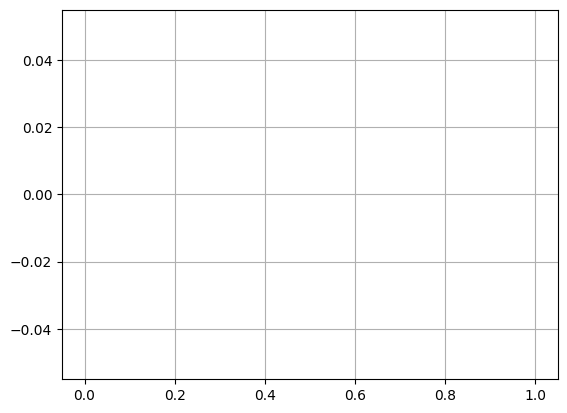

In [77]:
df[df["use_contractors"]==0]["water_and_emmissions"].hist()

In [78]:
df.columns

Index(['member_id', 'data_year_id', 'vineyard_area', 'area_harvested',
       'tonnes_grapes_harvested', 'water_used', 'total_tractor_passes',
       'total_vineyard_fuel', 'total_vineyard_electricity',
       'total_irrigation_area', 'synthetic_nitrogen_applied',
       'organic_nitrogen_applied', 'synthetic_fertiliser_applied',
       'organic_fertiliser_applied', 'area_not_harvested',
       'total_irrigation_electricity', 'total_irrigation_fuel', 'giregion',
       'fertilizer_s1', 'fertilizer_s2', 'fertilizer_s3', 'fertilizer_s4',
       'fertilizer_s5', 'fertilizer_o1', 'fertilizer_o2', 'fertilizer_o3',
       'fertilizer_o4', 'fertilizer_o5', 'vineyard_area_white_grapes',
       'vineyard_area_red_grapes', 'river_water', 'groundwater',
       'surface_water_dam', 'recycled_water_from_other_source', 'mains_water',
       'other_water', 'water_applied_for_frost_control', 'bare_soil',
       'annual_cover_crop', 'permanent_cover_crop_native',
       'permanent_cover_crop_non_native

In [79]:
df["use_renewables"] = df['irrigation_energy_solar'].replace({np.nan: 0}) +\
       df['vineyard_solar'].replace({np.nan: 0}) +\
       df['vineyard_wind'].replace({np.nan: 0}) +\
       df['biodiesel_vineyard'].replace({np.nan: 0})
df.loc[df["use_renewables"] > 0, "use_renewables"] = 1
df["use_renewables"] = df["use_renewables"].map({0: "No Renewables", 1: "Used Renewables"})
df["use_renewables"]

0       No Renewables
1       No Renewables
2       No Renewables
3       No Renewables
4       No Renewables
            ...      
6078    No Renewables
6079    No Renewables
6081    No Renewables
6082    No Renewables
6087    No Renewables
Name: use_renewables, Length: 5401, dtype: object

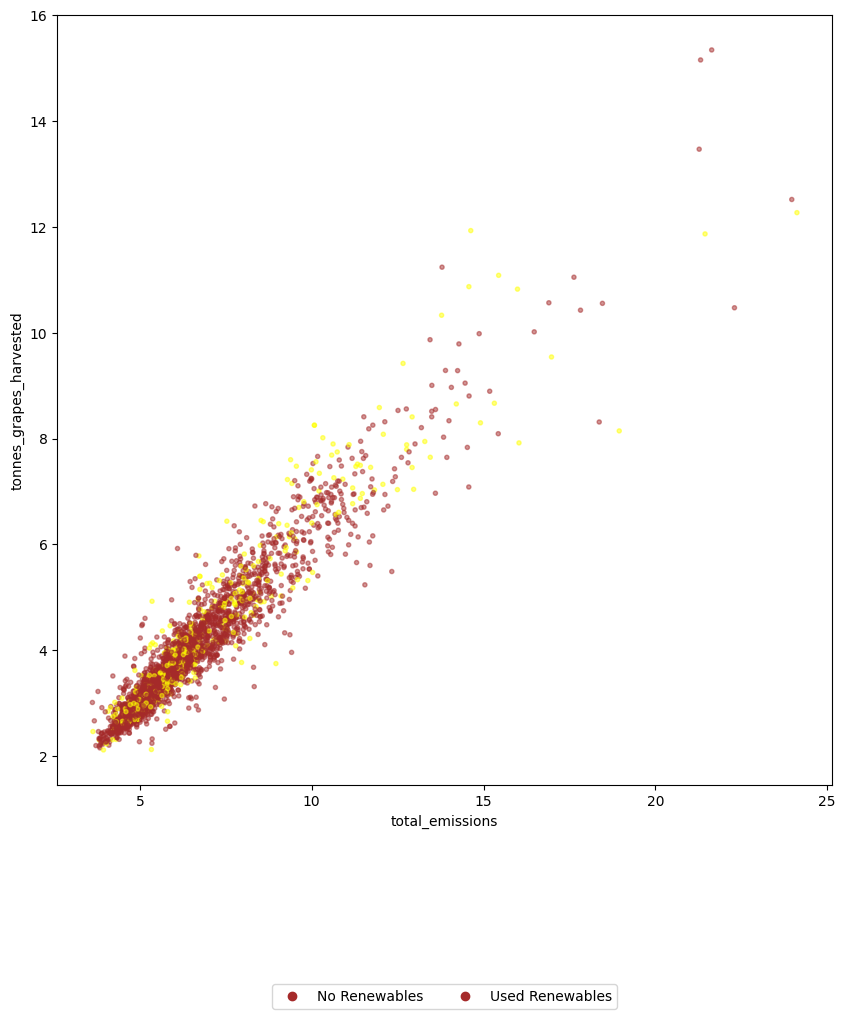

In [80]:
fig, ax = plt.subplots(figsize=(10, 10))

colors = {"No Renewables": "brown", "Used Renewables": "yellow"}

scatter = ax.scatter(
    df["water_and_emmissions"],
    df['yield_avg']
    , c=df["use_renewables"].map(colors)
    , label=df["use_renewables"]
    , marker= "."
    , alpha=0.5
)
ax.set_xlabel(feature)
ax.set_ylabel('tonnes_grapes_harvested')
ax.set(xlabel=feature, ylabel='tonnes_grapes_harvested')

markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in df["use_renewables"].map(colors).values]
plt.legend(markers, df["use_renewables"].unique(), loc='lower center', bbox_to_anchor=(0.5, -.3), ncol=6)

plt.show()